# Muon Data Example using RQ/ntuple file

This is an rather complicated analysis example using the ntuple files produced by DROP. I intended to dump a lot of stuff here. Please see the simpler example.

## Load package and define functions

In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from datetime import timedelta, datetime

import re
import os
import sys
from scipy.optimize import curve_fit
from scipy import interpolate
import glob
import yaml  # PyYAML 5.1 or later (pip install -U PyYAML)

In [2]:
def get_concatenated_data(data_path, var_names = None):
    """Get concatenated data

    This function loads root file via uproot one by one. Get variables
    specified by `var_names`, and concatenate them.

    Args:
        data_path (list, str): list of str, or str. Use str for a single file. Use a list of str for many files.
        var_names: list of variables to load. If None, load all.

    Returns:
        data: dict. Keys are specified by var_names.

    Examples:
        get_concatenated_data(data_path='path/to/run*/FitResults.root') will
    get data for all runs.

    Todo:
        uproot.lazyarrays is a better way to load data with selected branches. It requres awkarray installed.
    """
    if not data_path:
        print("ERROR: empty list. Check your input data_path: \n", data_path)
        return None
    if isinstance(data_path, str):
        data_path = [data_path]
    if var_names is None:
        f = uproot.open(data_path[0])
        var_names = f['event'].keys()

    data_dict = {}
    for p in data_path:
        with uproot.open(p) as f:
            tree = f['event']
            for var in var_names:
                tmp = tree[var].array(library="np")
                if var in data_dict.keys():
                    data_dict[var] = np.concatenate([data_dict[var], tmp])
                else:
                    data_dict[var]=tmp
    return data_dict

def get_listed_data(data_path, var_names = None):
    """Get data as a list

    This function is similar to get_concatenated_data, but instead of concatenating data from multiple files,
    it puts data from each file in a list. Each element of the list corresponds a file.
    This is to have a clear separation for data from different files.

    Args:
        data_path (list): list of str
        var_names: list of str.

    Returns:
        data: list. Not concatenated.
    """
    output = []
    for p in data_path:
        data_dict = get_concatenated_data(data_path=p, var_names = var_names)
        output.append(data_dict)
    return output

def get_listed_run_start_datetime(data_path):
    run_start = []
    for p in data_path:
        run_start.append( extract_datetime_from_str(p) )
    return run_start

def make_file_paths(data_dir, file_list):
    """
    Args:
        data_dir: directory to the data
        file_list: a list of filenames
    Return:
        add data_dir to each of file_list
    """
    paths =[]
    for item in file_list:
        if isinstance(item, str):
            paths.append(data_dir+'/'+item)
        elif type(item) == list:
            tmp = []
            for i in item:
                tmp.append(data_dir+'/'+i)
            paths.append(tmp)
        else:
            pass
    return paths


def extract_datetime_from_str(s):
    """
    Extract datatime from a str. The datetime must follow the fixed format:
    YYmmddTHHMM
    """
    import re
    from datetime import datetime
    match = re.search(r'\d{6}T\d{4}', s)
    try:
        dt = datetime.strptime(match.group(), '%y%m%dT%H%M')
        return dt
    except ValueError:
        print('Fail finding the datetime string from path: %s' % s)


"""
Needed for chi2 fitting
"""
def gauss(x, mu, sigma, N):
    """
    A gaussian function
    """
    arg = (x-mu)/sigma
    Norm=N*1/np.sqrt(2*np.pi)/sigma
    return Norm* np.exp(-0.5*arg*arg)

from scipy.stats import exponnorm, norm

def expo_gauss(x, mu, sigma, k, N):
    return N*exponnorm.pdf(x, k, loc=mu, scale=sigma)


def calc_chi2(func, xdata, ydata, popt):
    """
    Pearson chi2
    """
    y = func(xdata, *popt)
    r = (y-ydata)/np.sqrt(ydata)
    r2 = np.square(r)
    return np.sum(r2)

# def fit_curve(h, fit_range, p0=[1, 1, 1], color='black'):

#     ydata = h[0]
#     xdata = (h[1][1:]+h[1][:-1])/2
#     tot = np.trapz(ydata, xdata)
#     p0[2]=tot
#     bw = xdata[1]-xdata[0]
    
#     # 1st fit
#     fit_mask = (xdata>fit_range[0]) & (xdata<fit_range[1])
#     sigma = np.sqrt(ydata[fit_mask])
#     popt, pcov = curve_fit(gauss, xdata[fit_mask], ydata[fit_mask], sigma=sigma, p0=p0)
#     # 2nd fit
#     fit_range=[popt[0]-2*popt[1], popt[0]+2*popt[1]]
#     fit_mask = (xdata>fit_range[0]) & (xdata<fit_range[1])
#     sigma = np.sqrt(ydata[fit_mask])
#     popt, pcov = curve_fit(gauss, xdata[fit_mask], ydata[fit_mask], sigma=sigma, p0=p0)
#     x = np.linspace(xdata[fit_mask][0], xdata[fit_mask][-1], 100)    
#     y = gauss(x, popt[0], popt[1], 1)
    
#     chi2 = calc_chi2(gauss, xdata[fit_mask], ydata[fit_mask], popt)
#     dof = len(xdata[fit_mask])-2    
#     plt.plot(x, y*tot, color=color, label=r'Fit $(\mu=%d, \sigma=%d)$' %(popt[0], popt[1]))
    

def fit_gauss(h, fit_range, p0=[1, 1, 1]):
    """
    A function that fits binned data. It fits data twice.
    If covariance from the first fit is bad, do the second fit with smaller range
    
    Args:
        h: return of plt.hist
        fit_range: list of two float (ex. [1.0, 2.0] means fit range is from 1.0 to 2.0
    """
    ydata = h[0]
    xdata = (h[1][1:]+h[1][:-1])/2
    tot = np.trapz(ydata, xdata)
    p0[2]=tot
    bw = xdata[1]-xdata[0]
    # 1st fit
    fit_mask = (xdata>fit_range[0]) & (xdata<fit_range[1])
    sigma = np.sqrt(ydata[fit_mask])
    popt, pcov = curve_fit(gauss, xdata[fit_mask], ydata[fit_mask], sigma=sigma, p0=p0)
    if np.any(np.isinf(pcov)):
        # 2nd fit
        fit_range=[fit_range[0]+7, fit_range[1]-5]
        #fit_range=[popt[0]-1.1*popt[1], popt[0]+1.2*popt[1]]
        fit_mask = (xdata>fit_range[0]) & (xdata<fit_range[1])
        sigma = np.sqrt(ydata[fit_mask])
        popt, pcov = curve_fit(gauss, xdata[fit_mask], ydata[fit_mask], sigma=sigma, p0=p0)
    
    x = np.linspace(xdata[fit_mask][0], xdata[fit_mask][-1], 100)    
    y = gauss(x, popt[0], popt[1], 1)
    
    chi2 = calc_chi2(gauss, xdata[fit_mask], ydata[fit_mask], popt)
    dof = len(xdata[fit_mask])-2    
    
    err = np.diag(pcov)
    err = np.sqrt(err)
    
    return dict(
        x=x, 
        y=y*tot,
        popt=popt,
        chi2=chi2,
        dof=dof,
        err=err,
        nbin=len(xdata[fit_mask]),
    )

def fit_expo_gauss(h, fit_range, p0=[1, 1, 1, 1]):
    """
    Expo modified gaussian
    
    Args:
        h: return of plt.hist
        fit_range: list of two float (ex. [1.0, 2.0] means fit range is from 1.0 to 2.0
    """
    ydata = h[0]
    xdata = (h[1][1:]+h[1][:-1])/2
    tot = np.trapz(ydata, xdata)
    p0[2]=tot
    bw = xdata[1]-xdata[0]
    # 1st fit
    fit_mask = (xdata>fit_range[0]) & (xdata<fit_range[1])
    sigma = np.sqrt(ydata[fit_mask])
    popt, pcov = curve_fit(expo_gauss, xdata[fit_mask], ydata[fit_mask], sigma=sigma, p0=p0)
#     if np.any(np.isinf(pcov)):
#         # 2nd fit
#         fit_range=[fit_range[0], fit_range[1]-5]
#         #fit_range=[popt[0]-1.1*popt[1], popt[0]+1.2*popt[1]]
#         fit_mask = (xdata>fit_range[0]) & (xdata<fit_range[1])
#         sigma = np.sqrt(ydata[fit_mask])
#         popt, pcov = curve_fit(gauss, xdata[fit_mask], ydata[fit_mask], sigma=sigma, p0=p0)
    x = np.linspace(xdata[fit_mask][0], xdata[fit_mask][-1], 100)    
    y = expo_gauss(x, popt[0], popt[1], popt[2], 1)
    
    chi2 = calc_chi2(expo_gauss, xdata[fit_mask], ydata[fit_mask], popt)
    dof = len(xdata[fit_mask])-2    
    
    err = np.diag(pcov)
    err = np.sqrt(err)
    
    return dict(
        x=x, 
        y=y*tot,
        popt=popt,
        chi2=chi2,
        dof=dof,
        err=err,
        nbin=len(xdata[fit_mask]),
    )

## Look at a chunk of Pure Water data

In [7]:
DATA_DIR=''
filenames=[
    "phase1_muon_wbls_1pct_221101T0927_rq.root",
    "phase1_muon_wbls_1pct_221101T1718_rq.root",
    "phase1_muon_wbls_1pct_221102T0036_rq.root",
    "phase1_muon_wbls_1pct_221102T0904_rq.root",
    "phase1_muon_wbls_1pct_221102T1739_rq.root",
    "phase1_muon_wbls_1pct_221102T2341_rq.root",
    "phase1_muon_wbls_1pct_221103T0932_rq.root",
    "phase1_muon_wbls_1pct_221103T1740_rq.root",
    "phase1_muon_wbls_1pct_221103T2324_rq.root",
    "phase1_muon_wbls_1pct_221105T0744_rq.root",
    "phase1_muon_wbls_1pct_221105T1052_rq.root",
    "phase1_muon_wbls_1pct_221105T2202_rq.root",]

filepaths = make_file_paths('../data/rq/v1.0.2/', filenames)
rq = get_concatenated_data(filepaths)

In [8]:
from numpy import zeros


pulse_area = []
pulse_ptime = []
mu_event_id = []
mu_ptime = []
mu_max_frac = []
mu_max_ch = []
mu_area_bot = []
mu_area_side = []
mu_area_sum = []
mu_area_bot_crx = []
mu_area_side_crx = []
mu_area_sum_crx = []
mu_max_frac_crx = []
mu_max_ch_crx = []
mu_area_sum_crx_sat=[]

mu_area_sum_sat = []

for i in range(len(rq['pulse_id'])):
    if rq['event_sanity'][i]>0:
        continue
    if rq['npulse'][i] ==0:
        continue
    pulse_area.append(rq['pulse_area_sum_pe'][i][0])
    pulse_ptime.append(rq['pulse_ptime_ns'][i][0])
    if rq['pulse_ptime_ns'][i][0]>395 or rq['pulse_ptime_ns'][i][0]<365:
        continue
    if rq['event_saturated'][i]==1:
        mu_area_sum_sat.append(rq['pulse_area_sum_pe'][i][0])
        continue

    mu_ptime.append(rq['pulse_ptime_ns'][i][0])
    mu_max_frac.append(rq['pulse_area_max_frac'][i][0])
    mu_max_ch.append(rq['pulse_area_max_ch_id'][i][0])
    mu_area_bot.append(rq['pulse_area_bot_pe'][i][0])
    mu_area_side.append(rq['pulse_area_side_pe'][i][0])
    mu_area_sum.append(rq['pulse_area_sum_pe'][i][0])
    mu_event_id.append(rq['event_id'][i])
    
    pad_pC = rq['aux_ch_area_mV'][i]/50
    cross_muon = np.any(pad_pC>15)
    if cross_muon:
        mu_area_bot_crx.append(rq['pulse_area_bot_pe'][i][0])
        mu_area_side_crx.append(rq['pulse_area_side_pe'][i][0])
        mu_area_sum_crx.append(rq['pulse_area_sum_pe'][i][0])
        mu_max_frac_crx.append(rq['pulse_area_max_frac'][i][0])
        mu_max_ch_crx.append(rq['pulse_area_max_ch_id'][i][0])
        if rq['event_saturated'][i]==1:
            mu_area_sum_crx_sat.append(rq['pulse_area_sum_pe'][i][0])


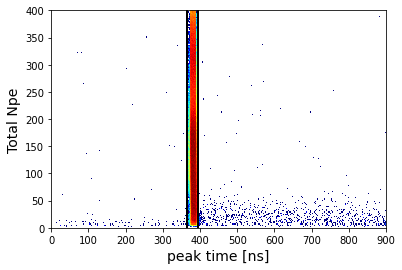

In [23]:
plt.figure()

plt.hist2d(pulse_ptime, pulse_area, bins=[450, 200], range=((0, 900), (0, 400)), 
                                                   norm=colors.LogNorm(), cmap='jet');
plt.vlines([365, 395], 0, 400, linewidth=2, color='k')
plt.xlabel('peak time [ns]', fontsize=14)
plt.ylabel('Total Npe', fontsize=14)
#plt.xlim([300, 500])
plt.show()

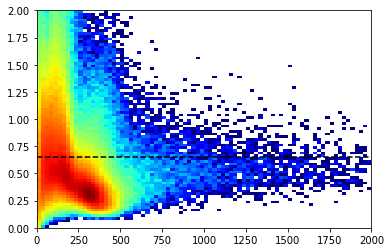

In [24]:
mu_area_sum=np.array(mu_area_sum)
mu_area_side=np.array(mu_area_side)
mu_area_bot = np.array(mu_area_bot)
sb=mu_area_side/mu_area_bot
plt.hist2d(mu_area_sum, sb, bins=80, range=((0, 2000), (0, 2)),
          norm=colors.LogNorm(), cmap='jet');
plt.hlines(0.65, 0, 2000, color='k', linestyle='--')
plt.show()

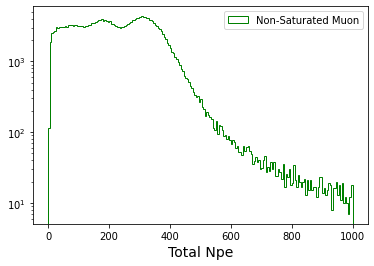

8133

In [34]:

plt.figure()
plot_range=[0, 1000]
nbinx = 200

mask = sb<0.65
plt.hist(mu_area_sum[mask], range=plot_range, bins=nbinx, label=r'Non-Saturated Muon',  
         histtype='step', color='green')
# plt.hist(mu_area_sum_sat, range=plot_range, bins=nbinx, label=r'Saturated Muon',  
#          histtype='step', color='red')
plt.xlabel('Total Npe', fontsize=14)
plt.yscale('log')
plt.legend()
plt.show()


mu_event_id=np.array(mu_event_id)
mask=(sb>0.75) & (mu_area_sum>250) & (mu_area_sum<500)
len(mu_event_id[mask])

In [29]:
len(mu_area_sum>250)

419327

14.045392964019662 6 [   61.64439535    13.94411122 12769.07273571]
24.746282652553276 19 [  313.41987633    42.59003208 12755.06546345]


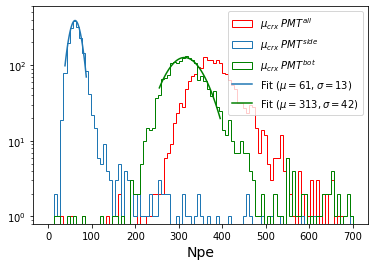

In [31]:
plt.figure()

plot_range=[0, 700]
nbinx = 100


# plt.hist(mu_area_sum, range=plot_range, bins=nbinx, label=r'$\sum PMT^{all}$', 
#          histtype='step', color='black')
# plt.hist(mu_area_side, range=plot_range, bins=nbinx, label=r'$\sum PMT^{side}$',  
#          histtype='step', color='tab:blue')
# plt.hist(mu_area_bot, range=plot_range, bins=nbinx, label=r'$\sum PMT^{bot}$', 
#          histtype='step', color='tab:green')

mu_max_frac_crx = np.array(mu_max_frac_crx)
mf_mask = mu_max_frac_crx<0.18
mu_area_sum_crx=np.array(mu_area_sum_crx)
mu_area_side_crx=np.array(mu_area_side_crx)
mu_area_bot_crx=np.array(mu_area_bot_crx)
plt.hist(mu_area_sum_crx[mf_mask], range=plot_range, bins=nbinx, label=r'$\mu_{crx}$ $PMT^{all}$',  
         histtype='step', color='red')
h1 = plt.hist(mu_area_side_crx[mf_mask], range=plot_range, bins=nbinx, label=r'$\mu_{crx}$ $PMT^{side}$', 
         histtype='step', color='tab:blue')
h2 = plt.hist(mu_area_bot_crx[mf_mask], range=plot_range, bins=nbinx, label=r'$\mu_{crx}$ $PMT^{bot}$',  
         histtype='step', color='green')

fit_curve(h1, fit_range=[35, 90], p0=[60, 7, len(mu_area_side_crx)], color='tab:blue')
fit_curve(h2, fit_range=[250, 400], p0=[320, 37, len(mu_area_bot_crx)], color='green')

# plt.ylim(1, 5e2)
plt.xlabel('Npe', fontsize=14)
plt.yscale('log')
plt.ylim(0.8, 6e2)
plt.legend()
plt.show()

/var/folders/j2/xx2nfy1d7kl54yfk4m9z36080000gn/T/ipykernel_49598/808499131.py:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


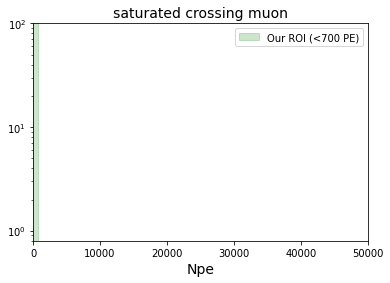

In [32]:
plt.hist(mu_area_sum_crx_sat, range=(0, 50000), bins=100,  histtype='step');
plt.xlabel('Npe', fontsize=14)
plt.yscale('log')
plt.title("saturated crossing muon", fontsize=14)
plt.axvspan(0, 700, color='green', alpha=0.2, label="Our ROI (<700 PE)")
plt.ylim(0.8, 1e2)
plt.xlim(0, 50000)
plt.legend()
plt.show()

In [35]:
len(mu_area_sum_crx)

2003

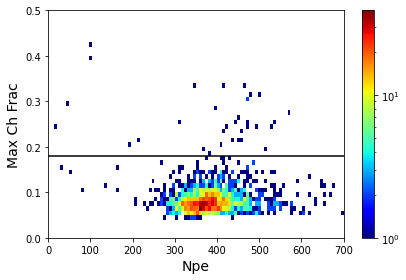

In [36]:
plt.figure()
plt.hist2d(mu_area_sum_crx, mu_max_frac_crx, bins=[100, 100], range=((0, 700), (0, 1)), 
                                                   norm=colors.LogNorm(), cmap='jet');
plt.colorbar()
plt.xlabel('Npe', fontsize=14)
plt.ylabel('Max Ch Frac', fontsize=14)
plt.hlines(0.18, 0, 1000, color='k')
plt.ylim([0, 0.5])
plt.tight_layout()
plt.show()

# Jar Data

In [2]:
DATA_DIR='../data'
filenames = [
    "phase0_muon_jarA_water_220902T1530_rq.root",
    "phase0_muon_jarA_water_220903T0848_rq.root",
    "phase0_muon_jarA_water_220904T0957_rq.root",
    'phase0_muon_jarA_water_220905T0959_rq.root',
]

filepaths = [DATA_DIR + '/' + fname for fname in filenames]

In [3]:
f = uproot.open(filepaths[0])

# print event tree structure
f['event'].show()

# get all rq names in a list
rq_names = f['event'].keys()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
event_id             | uint32_t                 | AsDtype('>u4')
event_ttt            | uint64_t                 | AsDtype('>u8')
event_sanity         | uint32_t                 | AsDtype('>u4')
ch_id                | uint16_t[46]             | AsDtype("('>u2', (46,))")
ch_roi0_height_pe    | float[46]                | AsDtype("('>f4', (46,))")
ch_roi1_height_pe    | float[46]                | AsDtype("('>f4', (46,))")
ch_roi2_height_pe    | float[46]                | AsDtype("('>f4', (46,))")
ch_roi0_area_pe      | float[46]                | AsDtype("('>f4', (46,))")
ch_roi1_area_pe      | float[46]                | AsDtype("('>f4', (46,))")
ch_roi2_area_pe      | float[46]                | AsDtype("('>f4', (46,))")
aux_ch_id            | uint16_t[2]              | AsDtype("('>u2', (2,))")
aux_ch_area_mV       | float[2]     

In [4]:
rq = get_concatenated_data(data_path=filepaths, var_names = rq_names)

In [5]:
rq.keys()

dict_keys(['event_id', 'event_ttt', 'event_sanity', 'ch_id', 'ch_roi0_height_pe', 'ch_roi1_height_pe', 'ch_roi2_height_pe', 'ch_roi0_area_pe', 'ch_roi1_area_pe', 'ch_roi2_area_pe', 'aux_ch_id', 'aux_ch_area_mV', 'npulse', 'pulse_id', 'pulse_start', 'pulse_end', 'pulse_area_sum_pe', 'pulse_area_bot_pe', 'pulse_area_side_pe', 'pulse_height_sum_pe', 'pulse_height_bot_pe', 'pulse_height_side_pe', 'pulse_sba', 'pulse_ptime_ns', 'pulse_coincidence', 'pulse_area_max_frac', 'pulse_area_max_ch_id'])

Text(0, 0.5, 'time sample [s]')

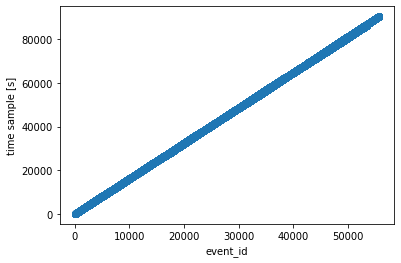

In [6]:
# check TTT
plt.scatter(rq['event_id'], rq['event_ttt']*8e-9)
plt.xlabel('event_id')
plt.ylabel('time sample [s]')

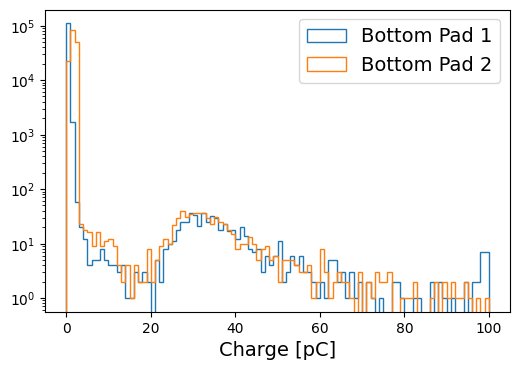

In [10]:

bp1_mask = rq['aux_ch_id']==100
bp2_mask = rq['aux_ch_id']==215

plt.figure(dpi=100)
plt.hist(rq['aux_ch_area_mV'][bp1_mask]/50, bins=100, range=(0, 100), histtype='step', label='Bottom Pad 1');
plt.hist(rq['aux_ch_area_mV'][bp2_mask]/50, bins=100, range=(0, 100), histtype='step', label='Bottom Pad 2');
plt.legend(fontsize=14)
plt.yscale('log')
plt.xlabel('Charge [pC]', fontsize=14)
plt.show()

In [8]:
# each event may have different npulse
bp1_mask = rq['aux_ch_id']==100
bp2_mask = rq['aux_ch_id']==215
area_bp1 = rq['aux_ch_area_mV'][bp1_mask]/50
area_bp2 =rq['aux_ch_area_mV'][bp2_mask]/50


mu_npe = []
mu_bp1_npe = []
mu_bp2_npe = []
for i in range(len(rq['pulse_id'])):
    npulse = rq['npulse'][i]
    if npulse==0:
        continue
    mu_npe.append(rq['pulse_area_sum_pe'][i][0])
    if area_bp1[i]>15:
        mu_bp1_npe.append(rq['pulse_area_sum_pe'][i][0])
    if area_bp2[i]>15:
        mu_bp2_npe.append(rq['pulse_area_sum_pe'][i][0])



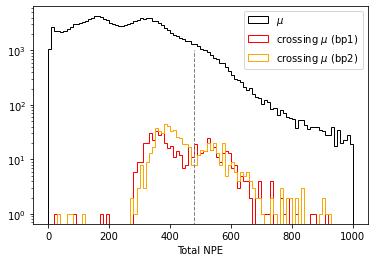

In [9]:
plt.hist(mu_npe, bins=100, range=(0, 1000), histtype='step', color='black', label=r'$\mu$');
plt.hist(mu_bp1_npe, bins=100, range=(0, 1000), histtype='step', color='red', label=r'crossing $\mu$ (bp1)');
plt.hist(mu_bp2_npe, bins=100, range=(0, 1000), histtype='step', color='orange', label=r'crossing $\mu$ (bp2)');

plt.vlines(480, 0, 1e3, linewidth=1, color='grey', linestyle='--')
# plt.vlines(500, 0, 1e3, linewidth=1, color='orange', linestyle='--')

plt.legend()
plt.yscale('log')
plt.xlabel('Total NPE')
plt.show()

In [18]:
"""dict_keys(['event_id', 'event_ttt', 
'event_sanity', 'ch_id', 'ch_roi0_height_pe', 
'ch_roi1_height_pe', 'ch_roi2_height_pe', 'ch_roi0_area_pe', 
'ch_roi1_area_pe', 'ch_roi2_area_pe', 'aux_ch_id', 
'aux_ch_area_mV', 'npulse', 'pulse_id', 'pulse_start', 'pulse_end', 
'pulse_area_sum_pe', 'pulse_area_bot_pe', 'pulse_area_side_pe', 
'pulse_height_sum_pe', 'pulse_height_bot_pe', 'pulse_height_side_pe', 'pulse_sba', 
'pulse_ptime_ns', 'pulse_coincidence', 'pulse_area_max_frac', 
'pulse_area_max_ch_id'])"""


mu_ptime = rq['pulse_ptime_ns']
mu_max_frac = rq['pulse_area_max_frac']
mu_max_ch = rq['pulse_area_max_ch_id']

200517

In [10]:
mu_cross_id = []
mu_cross_npe = []
for i in range(len(rq['pulse_id'])):
    npulse = rq['npulse'][i]
    if npulse==0:
        continue
    mu_npe.append(rq['pulse_area_sum_pe'][i][0])
    if area_bp1[i]>15 or area_bp2[i]>15:
        mu_cross_id.append(rq['event_id'][i])
        mu_cross_npe.append(rq['pulse_area_sum_pe'][i][0])

mu_cross_id=np.array(mu_cross_id)
mu_cross_npe=np.array(mu_cross_npe)
jar_mask = mu_cross_npe>480
print(mu_cross_id[jar_mask])
print(len(mu_cross_id[jar_mask]))

[   60   430   653   844  1027  1503  1763  1865  2447  2665  2666  2819
  2882  2922  2931  3525  3671  4316  4414  4455  4600  4762  4047  5044
  5633  5736  6543  7090  7202  7992  8790  8835  9616  9750  9877 10346
 10841 10946 11292 11456 11554 11649 11708 12764 12789 13384 14521 14720
 14840 14010 15106 15112 15173 15255 15590 15859 16492 16514 16289 16296
 17654 17964 18686 18845 18037 18044 18160 19276 19352 19604 19721 19777
 21170 21375 21530 21542 21859 21863 21985 21992 22732 23238 23674 24359
 25396 25409 25484 25633 25816 26913 26003 26296 26346 26506 28174 28605
 29129 29272 29659 30359 30654 31099 31120 31616 31782 32015 32106 32137
 32251 32352 32666 33375 33643 33841 34532 34731 35008 35449 35458 35790
 35950 36590 36694 37657   825  1133  1172  1227  1447  1486  1585  1853
  3518  3546  3705  3779  4191  4225  4716  4919  4091  5011  5017  5079
  5132  5538  5639  5997  6443  6463  6779  6103  7626  7814  8510  8650
  8103  8125 10270 10453 11226 11428 11647 12584 12

# Crossing mion in Water vs Time

In [7]:
from datetime import datetime


#[ "phase0_muon_water_220918T0002_rq.root","phase0_muon_water_220918T0854_rq.root","phase0_muon_water_220918T1459_rq.root", 
#    "phase0_muon_water_220918T1559_rq.root","phase0_muon_water_220918T2112_rq.root","phase0_muon_water_220918T2328_rq.root",]

file_list = [
    "phase0_muon_water_220819T1500_rq.root",
    "phase0_muon_water_220820T1150_rq.root",
    "phase0_muon_water_220822T0959_rq.root",
    "phase0_muon_water_220823T1100_rq.root",
    "phase0_muon_water_220824T1010_rq.root",
    ["phase0_muon_water_220825T1100_rq.root", "phase0_muon_water_220826T0955_rq.root",],
    ["phase0_muon_water_220830T1136_rq.root", "phase0_muon_water_220830T1958_rq.root"],

    "phase0_muon_water_220831T2052_rq.root",
    ["phase0_muon_water_220901T1040_rq.root","phase0_muon_water_220901T2011_rq.root"],
    
    ["phase0_muon_water_220907T1540_rq.root", "phase0_muon_water_220907T1633_rq.root","phase0_muon_water_220907T2200_rq.root"],
    ["phase0_muon_water_220908T1000_rq.root", "phase0_muon_water_220908T1405_rq.root", "phase0_muon_water_220908T1947_rq.root"],
    ["phase0_muon_water_220909T1007_rq.root", "phase0_muon_water_220909T1502_rq.root","phase0_muon_water_220909T2202_rq.root"],
    ["phase0_muon_water_220910T0013_rq.root", "phase0_muon_water_220910T0902_rq.root"],
    ["phase0_muon_water_220911T0050_rq.root", "phase0_muon_water_220911T0922_rq.root", "phase0_muon_water_220911T1516_rq.root", "phase0_muon_water_220911T2200_rq.root"],
    ["phase0_muon_water_220912T1439_rq.root", "phase0_muon_water_220912T1735_rq.root", "phase0_muon_water_220913T0036_rq.root", "phase0_muon_water_220913T0831_rq.root", "phase0_muon_water_220913T1107_rq.root", "phase0_muon_water_220913T2307_rq.root"],
    ["phase0_muon_water_220914T0019_rq.root", "phase0_muon_water_220914T0939_rq.root", "phase0_muon_water_220914T1802_rq.root"],
    ["phase0_muon_water_220915T0002_rq.root", "phase0_muon_water_220915T0955_rq.root", "phase0_muon_water_220915T2110_rq.root"],
    ["phase0_muon_water_220916T0109_rq.root", "phase0_muon_water_220916T0908_rq.root", "phase0_muon_water_220916T1826_rq.root"], 
    ["phase0_muon_water_220917T0020_rq.root","phase0_muon_water_220917T0835_rq.root","phase0_muon_water_220917T2131_rq.root"],
    ["phase0_muon_water_220918T0002_rq.root","phase0_muon_water_220918T0854_rq.root","phase0_muon_water_220918T1459_rq.root","phase0_muon_water_220918T1559_rq.root","phase0_muon_water_220918T2112_rq.root","phase0_muon_water_220918T2328_rq.root",],

    [ "phase0_muon_water_220920T0054_rq.root", "phase0_muon_water_220920T1046_rq.root", "phase0_muon_water_220920T1725_rq.root",]

]



file_paths = make_file_paths('../data/rq/v1.0.0', file_list)

# for i in file_paths:
#     print(i)

start_time_str = [
    "220819T1500",
    "220820T1150",
    "220822T0959",
    "220823T1100",
    "220824T1010",
    "220825T1100",
    #"220826T0955",
    "220830T1136",
    #"220830T1958",
    "220831T2052",
    "220901T1040",
    #"220901T2011",
    "220907T1540",
    "220908T1000",
    "220909T1007",
    "220910T0013",
    "220911T0050",
    "220912T1439",
    
#     "220913T0036",
    "220914T0019",
    "220915T0002",
    "220916T0109",
    "220917T0020",
    "220918T0002",

    "220920T0054",
]

run_start_time = [ datetime.strptime(s, "%y%m%dT%H%M") for s in start_time_str ]

In [8]:
# from datetime import datetime


# file_paths = [
#     ["../data/rq/v1.0.0/phase0_muon_water_220819T1500_rq.root",
#     "../data/rq/v1.0.0/phase0_muon_water_220820T1150_rq.root",
#     "../data/rq/v1.0.0/phase0_muon_water_220822T0959_rq.root",
#     "../data/rq/v1.0.0/phase0_muon_water_220823T1100_rq.root",
#     "../data/rq/v1.0.0/phase0_muon_water_220824T1010_rq.root",
#     "../data/rq/v1.0.0/phase0_muon_water_220825T1100_rq.root", "../data/rq/v1.0.0/phase0_muon_water_220826T0955_rq.root",],
    
#     ["../data/rq/v1.0.0/phase0_muon_water_220830T1136_rq.root", "../data/rq/v1.0.0/phase0_muon_water_220830T1958_rq.root",
#     "../data/rq/v1.0.0/phase0_muon_water_220831T2052_rq.root",
#     "../data/rq/v1.0.0/phase0_muon_water_220901T1040_rq.root","../data/rq/v1.0.0/phase0_muon_water_220901T2011_rq.root"],
    
#     ["../data/rq/v1.0.0/phase0_muon_water_220907T1540_rq.root", "../data/rq/v1.0.0/phase0_muon_water_220907T1633_rq.root","../data/rq/v1.0.0/phase0_muon_water_220907T2200_rq.root",
#     "../data/rq/v1.0.0/phase0_muon_water_220908T1000_rq.root", "../data/rq/v1.0.0/phase0_muon_water_220908T1405_rq.root", "../data/rq/v1.0.0/phase0_muon_water_220908T1947_rq.root",
#     "../data/rq/v1.0.0/phase0_muon_water_220909T1007_rq.root", "../data/rq/v1.0.0/phase0_muon_water_220909T1502_rq.root","../data/rq/v1.0.0/phase0_muon_water_220909T2202_rq.root",
#     "../data/rq/v1.0.0/phase0_muon_water_220910T0013_rq.root", "../data/rq/v1.0.0/phase0_muon_water_220910T0902_rq.root",
#     "../data/rq/v1.0.0/phase0_muon_water_220911T0050_rq.root", "../data/rq/v1.0.0/phase0_muon_water_220911T0922_rq.root", "../data/rq/v1.0.0/phase0_muon_water_220911T1516_rq.root", "../data/rq/v1.0.0/phase0_muon_water_220911T2200_rq.root",
#     "../data/rq/v1.0.0/phase0_muon_water_220912T1439_rq.root", "../data/rq/v1.0.0/phase0_muon_water_220912T1735_rq.root"],



# ]

# start_time_str = [
#     "220823T1100",

#     "220901T1040",


#     "220909T1007",
# ]

# run_start_time = [ datetime.strptime(s, "%y%m%dT%H%M") for s in start_time_str ]

In [9]:
f = uproot.open(file_paths[0])
rq_list = get_listed_data(file_paths, var_names=f['event'].keys())


2022-08-19 15:00:00
2022-08-20 11:50:00
2022-08-22 09:59:00
2022-08-23 11:00:00
2022-08-24 10:10:00
2022-08-25 11:00:00
2022-08-30 11:36:00
2022-08-31 20:52:00
2022-09-01 10:40:00
2022-09-07 15:40:00
2022-09-08 10:00:00


/Users/xxiang/MyGitHub/Gmail/drop/env/lib/python3.8/site-packages/scipy/optimize/minpack.py:756: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/Users/xxiang/MyGitHub/Gmail/drop/env/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


2022-09-09 10:07:00
2022-09-10 00:13:00
2022-09-11 00:50:00
2022-09-12 14:39:00


/Users/xxiang/MyGitHub/Gmail/drop/env/lib/python3.8/site-packages/scipy/optimize/minpack.py:756: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/Users/xxiang/MyGitHub/Gmail/drop/env/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


2022-09-14 00:19:00
2022-09-15 00:02:00
2022-09-16 01:09:00
2022-09-17 00:20:00


/Users/xxiang/MyGitHub/Gmail/drop/env/lib/python3.8/site-packages/scipy/optimize/minpack.py:756: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/Users/xxiang/MyGitHub/Gmail/drop/env/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/j2/xx2nfy1d7kl54yfk4m9z36080000gn/T/ipykernel_52334/3158280380.py:100: RuntimeWarning: divide by zero encountered in true_divide
  r = (y-ydata)/np.sqrt(ydata)


2022-09-18 00:02:00
2022-09-20 00:54:00


/Users/xxiang/MyGitHub/Gmail/drop/env/lib/python3.8/site-packages/scipy/optimize/minpack.py:756: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/Users/xxiang/MyGitHub/Gmail/drop/env/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/j2/xx2nfy1d7kl54yfk4m9z36080000gn/T/ipykernel_52334/3158280380.py:100: RuntimeWarning: divide by zero encountered in true_divide
  r = (y-ydata)/np.sqrt(ydata)


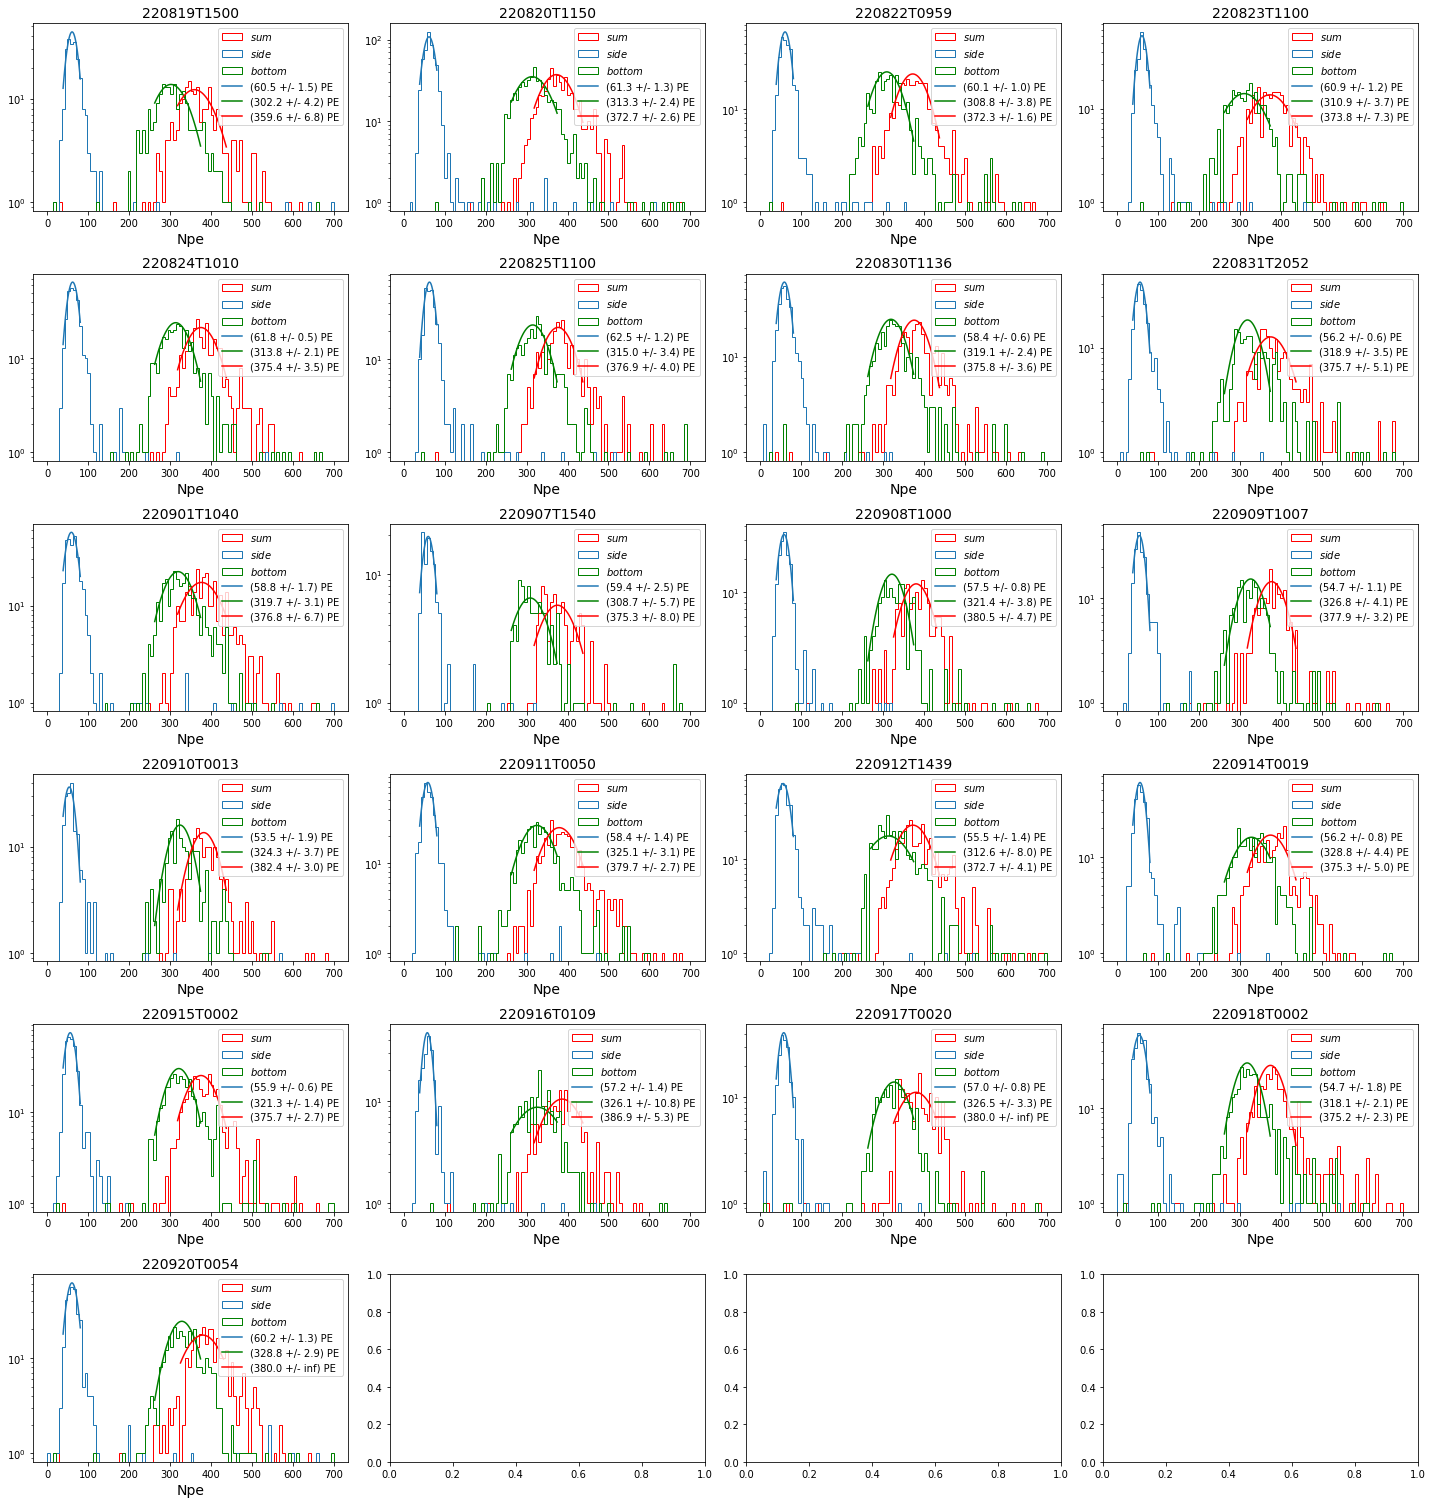

In [10]:
plot_range=[0, 700]
nbinx=100

ncol=4
nrow=len(rq_list)//ncol+1
fig, ax = plt.subplots(nrow, ncol, figsize=[5*ncol,3.5*nrow])
ax = ax.flatten()
fit_side = []
fit_bot = []
fit_sum = []
run_t0 = []
run_duration_s = []
for r, rq in enumerate(rq_list):
    print(run_start_time[r])
    run_t0.append(run_start_time[r])
    run_duration_s.append( (rq['event_ttt'][-1]-rq['event_ttt'][0])*8e-9 )
    #print(start_time_str[r], run_duration_s)
    mu_npe_bot_crx=[]
    mu_npe_side_crx=[]
    mu_npe_sum_crx=[]
    mu_area_sum_sat=[]
    for i in range(len(rq['npulse'])):
        if rq['event_sanity'][i]>0:
            continue
        if rq['npulse'][i] ==0:
            continue
#         if rq['pulse_ptime_ns'][i][0]>395 or rq['pulse_ptime_ns'][i][0]<365:
#             continue
        if rq['event_saturated'][i]==1:
            mu_area_sum_sat.append(rq['pulse_area_sum_pe'][i][0])
            continue
        if rq['pulse_area_max_frac'][i][0]>0.18:
            continue
        pad_pC = rq['aux_ch_area_mV'][i]/50
        cross_muon = np.any(pad_pC>15)
        if cross_muon:
            mu_npe_bot_crx.append(rq['pulse_area_bot_pe'][i][0])
            mu_npe_side_crx.append(rq['pulse_area_side_pe'][i][0])
            mu_npe_sum_crx.append(rq['pulse_area_sum_pe'][i][0])

    h0 = ax[r].hist(mu_npe_sum_crx, range=plot_range, bins=nbinx, label=r'$sum$',  
         histtype='step', color='red')
    h1 = ax[r].hist(mu_npe_side_crx, range=plot_range, bins=nbinx, label=r'$side$', 
         histtype='step', color='tab:blue')
    h2 = ax[r].hist(mu_npe_bot_crx, range=plot_range, bins=nbinx, label=r'$bottom$',  
         histtype='step', color='green')
    
    fit1 = fit_curve(h1, fit_range=[37, 87], p0=[61, 7, len(mu_npe_side_crx)], color='tab:blue')
    fit2 = fit_curve(h2, fit_range=[260, 380], p0=[320, 40, len(mu_npe_bot_crx)], color='green')
    fit0 = fit_curve(h0, fit_range=[315, 440], p0=[380, 47, len(mu_npe_sum_crx)], color='tab:red')
    mu1=fit1['popt'][0]
    mu2=fit2['popt'][0]
    mu0=fit0['popt'][0]
    mu1_err = fit1['err'][0]
    mu2_err = fit2['err'][0]
    mu0_err = fit0['err'][0]
    ax[r].plot(fit1['x'], fit1['y'], color='tab:blue',  label="(%.1f +/- %.1f) PE" % (mu1, mu1_err))
    ax[r].plot(fit2['x'], fit2['y'], color='green',  label="(%.1f +/- %.1f) PE" % (mu2, mu2_err))
    ax[r].plot(fit0['x'], fit0['y'], color='red', label="(%.1f +/- %.1f) PE" % (mu0, mu0_err))
    fit_side.append(fit1)
    fit_bot.append(fit2)
    fit_sum.append(fit0)

    ax[r].set_xlabel('Npe', fontsize=14)
    ax[r].set_yscale('log')
    ax[r].set_title(start_time_str[r], fontsize=14)
    ax[r].legend(fontsize=10, loc='upper right')
plt.tight_layout()
plt.show()

In [11]:
len(run_t0)

21

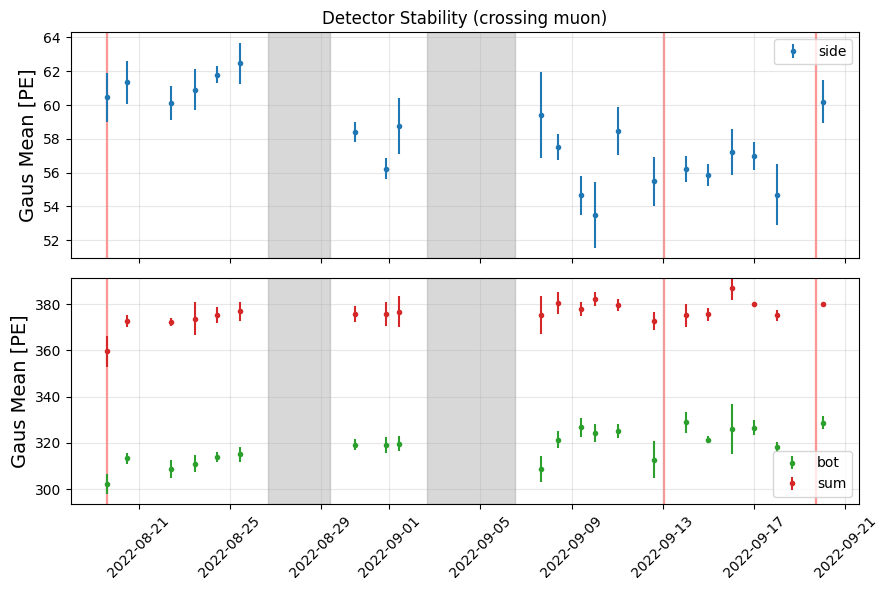

In [12]:

fig, ax = plt.subplots(2, 1, figsize=[9,6], sharex=True, dpi=100)
mu = [res['popt'][0] for res in fit_side]
err = [res['err'][0] for res in fit_side]
# sigma = np.array([res['popt'][1] for res in fit_side])
# nbin = np.array([res['nbin'] for res in fit_side])
# err=sigma/np.sqrt(nbin)
ax[0].errorbar(run_t0, mu, yerr=err, color='tab:blue', label='side',  marker='.', linestyle = 'None',)
ax[0].set_title('Detector Stability (crossing muon)')

mu = [res['popt'][0] for res in fit_bot]
err = [res['err'][0] for res in fit_bot]
# sigma = np.array([res['popt'][1] for res in fit_bot])
# nbin = np.array([res['nbin'] for res in fit_bot])
# err=sigma/np.sqrt(nbin)
ax[1].errorbar(run_t0, mu, yerr=err, color='tab:green', label='bot',  marker='.', linestyle = 'None',)
mu = [res['popt'][0] for res in fit_sum]
err = [res['err'][0] for res in fit_sum]



# sigma = np.array([res['popt'][1] for res in fit_sum])
# nbin = np.array([res['nbin'] for res in fit_sum])
# err=sigma/np.sqrt(nbin)
ax[1].errorbar(run_t0, mu, yerr=err, color='tab:red', label='sum',  marker='.', linestyle = 'None',)

jarC_start = datetime.strptime('220826T1600', "%y%m%dT%H%M")
jarC_end = datetime.strptime('220829T0930', "%y%m%dT%H%M")

jarA_start = datetime.strptime('220902T1530', "%y%m%dT%H%M")
jarA_end = datetime.strptime('220906T1200', "%y%m%dT%H%M")

led1_start=datetime.strptime('220819T1410', "%y%m%dT%H%M")
led1_end=datetime.strptime('220819T1510', "%y%m%dT%H%M")

led2_start=datetime.strptime('220913T0000', "%y%m%dT%H%M")
led2_end=datetime.strptime('220913T0100', "%y%m%dT%H%M")

led3_start=datetime.strptime('220919T1600', "%y%m%dT%H%M")
led3_end=datetime.strptime('220919T1730', "%y%m%dT%H%M")

for i in range(2):
    ax[i].axvspan(jarC_start, jarC_end, alpha=0.3, color='grey')
    ax[i].axvspan(jarA_start, jarA_end, alpha=0.3, color='grey')
    ax[i].axvspan(led1_start, led1_end, alpha=0.3, color='red')
    ax[i].axvspan(led2_start, led2_end, alpha=0.3, color='red')
    ax[i].axvspan(led3_start, led3_end, alpha=0.3, color='red')
    ax[i].set_ylabel('Gaus Mean [PE]', fontsize=14)
    ax[i].grid(alpha=0.3)
    ax[i].legend()
    

plt.xticks(rotation=45)
fig.tight_layout()


# plt.ylim([280, 400])
plt.show()


In [13]:
# track b3_p1
plot_range=[0, 100]
nbinx=100

ncol=4
nrow=len(rq_list)//ncol+1
fig, ax = plt.subplots(nrow, ncol, figsize=[5*ncol,3.5*nrow])
ax = ax.flatten()
spread = []
med = []
mean1={308: [], 309: []}
mean2={308: [], 309: []}
for r, rq in enumerate(rq_list):
    print(run_start_time[r])
    run_duration_s.append( (rq['event_ttt'][-1]-rq['event_ttt'][0])*8e-9 )
    #print(start_time_str[r], run_duration_s)

    ch_roi1=[]
    ch_id=[]
    for i in range(len(rq['npulse'])):
        if rq['event_sanity'][i]>0:
            continue
        if rq['npulse'][i] ==0:
            continue
        if rq['pulse_ptime_ns'][i][0]>395 or rq['pulse_ptime_ns'][i][0]<365:
            continue
        ch_roi1.append(rq['ch_roi1_area_pe'][i])
        ch_id.append(rq['ch_id'][i])
    ch_roi1=np.array(ch_roi1)
    ch_id=np.array(ch_id)
    qx = np.quantile(ch_roi1, [0.5, 0.9], axis=1)
    med.append(qx[0])
    spread.append(qx[1]-qx[0])
    mean = np.mean(ch_roi1, axis=0)
    
    for i in range(len(ch_id)):
        for k in range(len(ch_id[i])):
            if ch_id[i][k]==308:
                ax[r].hist(ch_roi1[i][k], range=plot_range, bins=nbinx, label=r'b3_p1 (ROI 1 Area)', 
                                histtype='step', color='blue')
            elif ch_id[i][k]==308:
                ax[r].hist(ch_roi1[i][k], range=plot_range, bins=nbinx, label=r'b3_p2 (ROI 1 Area)', 
             histtype='step', color='green')
            else:
                pass
    
    for k in range(len(ch_id[0])):
        if ch_id[0][k]==308:
            ax[r].vlines(mean[k], 0.1, 1e4, color='blue', linestyle='--', label='mean')
        else:
            ax[r].vlines(mean[k], 0.1, 1e4, color='green', linestyle='--', label='mean')


#     ax[r].vlines(mean2[-1], 0.1, 1e4, color='green', linestyle='--', label='mean')
#     fit1 = fit_curve(h1, fit_range=[37, 87], p0=[61, 7, len(mu_npe_side_crx)], color='tab:blue')
#     fit2 = fit_curve(h2, fit_range=[260, 380], p0=[320, 40, len(mu_npe_bot_crx)], color='green')
#     fit0 = fit_curve(h0, fit_range=[315, 440], p0=[380, 47, len(mu_npe_sum_crx)], color='tab:red')
#     mu1=fit1['popt'][0]
#     mu2=fit2['popt'][0]
#     mu0=fit0['popt'][0]
#     mu1_err = fit1['err'][0]
#     mu2_err = fit2['err'][0]
#     mu0_err = fit0['err'][0]
#     ax[r].plot(fit1['x'], fit1['y'], color='tab:blue',  label="(%.1f +/- %.1f) PE" % (mu1, mu1_err))
#     ax[r].plot(fit2['x'], fit2['y'], color='green',  label="(%.1f +/- %.1f) PE" % (mu2, mu2_err))
#     ax[r].plot(fit0['x'], fit0['y'], color='red', label="(%.1f +/- %.1f) PE" % (mu0, mu0_err))
#     fit_side.append(fit1)
#     fit_bot.append(fit2)
#     fit_sum.append(fit0)

    ax[r].set_xlabel('Npe', fontsize=14)
    ax[r].set_yscale('log')
    ax[r].set_title(start_time_str[r], fontsize=14)
    ax[r].legend(fontsize=10, loc='upper right')
plt.tight_layout()
plt.show()


2022-08-19 15:00:00
2022-08-20 11:50:00
2022-08-22 09:59:00
2022-08-23 11:00:00
2022-08-24 10:10:00
2022-08-25 11:00:00
2022-08-30 11:36:00
2022-08-31 20:52:00
2022-09-01 10:40:00
2022-09-07 15:40:00
2022-09-08 10:00:00
2022-09-09 10:07:00
2022-09-10 00:13:00
2022-09-11 00:50:00
2022-09-12 14:39:00
2022-09-14 00:19:00
2022-09-15 00:02:00
2022-09-16 01:09:00
2022-09-17 00:20:00
2022-09-18 00:02:00
2022-09-20 00:54:00


/var/folders/j2/xx2nfy1d7kl54yfk4m9z36080000gn/T/ipykernel_52334/2361130907.py:75: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


ValueError: Image size of 1169x1929871 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1440x1512 with 24 Axes>

In [94]:
run_t0

[datetime.datetime(2022, 8, 19, 15, 0),
 datetime.datetime(2022, 8, 20, 11, 50),
 datetime.datetime(2022, 8, 22, 9, 59),
 datetime.datetime(2022, 8, 23, 11, 0),
 datetime.datetime(2022, 8, 24, 10, 10),
 datetime.datetime(2022, 8, 25, 11, 0),
 datetime.datetime(2022, 8, 30, 11, 36),
 datetime.datetime(2022, 8, 31, 20, 52),
 datetime.datetime(2022, 9, 1, 10, 40),
 datetime.datetime(2022, 9, 7, 15, 40),
 datetime.datetime(2022, 9, 8, 10, 0),
 datetime.datetime(2022, 9, 9, 10, 7),
 datetime.datetime(2022, 9, 10, 0, 13),
 datetime.datetime(2022, 9, 11, 0, 50),
 datetime.datetime(2022, 9, 12, 14, 39),
 datetime.datetime(2022, 9, 14, 0, 19),
 datetime.datetime(2022, 9, 15, 0, 2),
 datetime.datetime(2022, 9, 16, 1, 9),
 datetime.datetime(2022, 9, 17, 0, 20)]

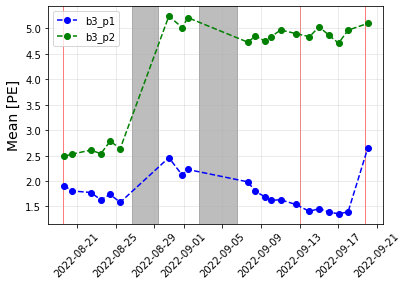

In [125]:
plt.plot(run_t0, mean1[308], color='blue', marker='o', linestyle = '--', label='b3_p1')
plt.plot(run_t0, mean1[309], color='green', marker='o', linestyle = '--', label='b3_p2')
for i in range(2):
    plt.axvspan(jarC_start, jarC_end, alpha=0.3, color='grey')
    plt.axvspan(jarA_start, jarA_end, alpha=0.3, color='grey')
    plt.axvspan(led1_start, led1_end, alpha=0.3, color='red')
    plt.axvspan(led2_start, led2_end, alpha=0.3, color='red')
    plt.axvspan(led3_start, led3_end, alpha=0.3, color='red')
    plt.ylabel('Mean [PE]', fontsize=14)
    plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.legend()
plt.show()

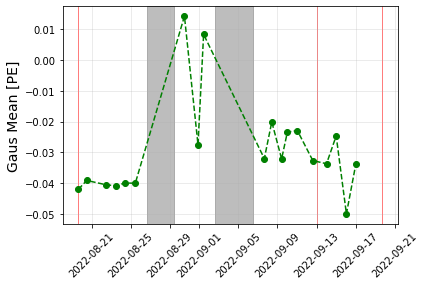

In [107]:
plt.plot(run_t0, mean2, color='green', marker='o', linestyle = '--')
for i in range(2):
    plt.axvspan(jarC_start, jarC_end, alpha=0.3, color='grey')
    plt.axvspan(jarA_start, jarA_end, alpha=0.3, color='grey')
    plt.axvspan(led1_start, led1_end, alpha=0.3, color='red')
    plt.axvspan(led2_start, led2_end, alpha=0.3, color='red')
    plt.axvspan(led3_start, led3_end, alpha=0.3, color='red')
    plt.ylabel('Gaus Mean [PE]', fontsize=14)
    plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.show()

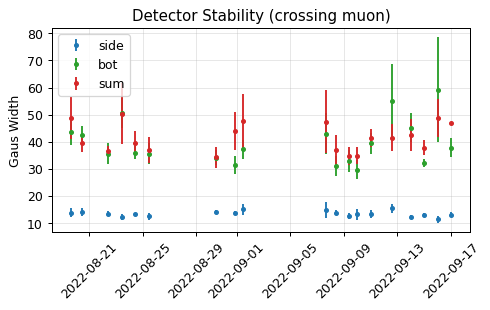

In [74]:
plt.figure(dpi=90, figsize=[6,3])
mu = [res['popt'][1] for res in fit_side]
err = [res['err'][1] for res in fit_side]
plt.errorbar(run_t0, mu, yerr=err, color='tab:blue', label='side', marker='.', linestyle = 'None',)
mu = [res['popt'][1] for res in fit_bot]
err = [res['err'][1] for res in fit_bot]
plt.errorbar(run_t0, mu, yerr=err, color='tab:green', label='bot', marker='.', linestyle = 'None',)
mu = [res['popt'][1] for res in fit_sum]
err = [res['err'][1] for res in fit_sum]
err = np.array(err)
err[err==np.inf]=0
plt.errorbar(run_t0, mu, yerr=err, color='tab:red', label='sum', marker='.', linestyle = 'None',)
plt.xticks(rotation=45)
plt.legend()
plt.title('Detector Stability (crossing muon)')
plt.ylabel('Gaus Width')
plt.grid(alpha=0.3)
plt.show()


In [4]:
f = uproot.open('../data/phase0_muon_jarA_water_220902T1530_rq.root')

In [5]:
f['event'].show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
event_id             | uint32_t                 | AsDtype('>u4')
event_ttt            | uint64_t                 | AsDtype('>u8')
event_sanity         | uint32_t                 | AsDtype('>u4')
event_saturated      | bool                     | AsDtype('bool')
ch_id                | uint16_t[46]             | AsDtype("('>u2', (46,))")
ch_saturated         | bool[46]                 | AsDtype("('?', (46,))")
ch_roi0_height_pe    | float[46]                | AsDtype("('>f4', (46,))")
ch_roi1_height_pe    | float[46]                | AsDtype("('>f4', (46,))")
ch_roi2_height_pe    | float[46]                | AsDtype("('>f4', (46,))")
ch_roi0_area_pe      | float[46]                | AsDtype("('>f4', (46,))")
ch_roi1_area_pe      | float[46]                | AsDtype("('>f4', (46,))")
ch_roi2_area_pe      | float[46]               

In [17]:
t = f['event']
rq = t.arrays(['event_id', 'event_saturated', 
               'ch_id', 'ch_saturated', 
               'pulse_id', 'pulse_saturated'], library='np')

In [19]:
mask_sat = rq['event_saturated']
event_id_sat = rq['event_id'][mask_sat]
ch_id_sat = rq['ch_id'][mask_sat]
ch_saturated_sat = rq['ch_saturated'][mask_sat]
pulse_id_sat = rq['pulse_id'][mask_sat]
pulse_saturated_sat = rq['pulse_saturated'][mask_sat]


In [22]:
for i in range(len(event_id_sat)):
    if i>10:
        continue
    print('event_id:', event_id_sat[i])
    for j, ch_id in enumerate(ch_id_sat[i]):
        if ch_saturated_sat[i][j]:
            print('ch_id:', ch_id)
    for j, pluse_id in enumerate(pulse_id_sat[i]):
        if pulse_saturated_sat[i][j]:
            print('pulse_id:', pluse_id)

event_id: 28
ch_id: 110
event_id: 95
ch_id: 115
event_id: 106
ch_id: 208
pulse_id: 0
event_id: 169
ch_id: 213
pulse_id: 0
event_id: 222
ch_id: 202
pulse_id: 0
event_id: 481
ch_id: 303
pulse_id: 0
event_id: 497
ch_id: 302
pulse_id: 0
event_id: 532
ch_id: 306
pulse_id: 0
event_id: 574
ch_id: 303
pulse_id: 0
event_id: 586
ch_id: 105
event_id: 645
ch_id: 203
pulse_id: 0


# WbLS data (first two hours)

In [301]:
data_files=['phase1_muon_wbls_1pct_220921T1351_rq.root']
file_paths = make_file_paths('../data/rq/v1.0.1/', data_files)

In [191]:
f = uproot.open(file_paths[0])
rq = get_concatenated_data(file_paths, var_names=f['event'].keys())

In [192]:
pulse_area = []
pulse_ptime = []
mu_ptime = []
mu_max_frac = []
mu_max_ch = []
mu_area_bot = []
mu_area_side = []
mu_area_row1 = []
mu_area_row2 = []
mu_area_sum = []
mu_area_sum_sat = []
mu_ttt = []
mu_id=[]

for i in range(len(rq['pulse_id'])):
    if rq['event_sanity'][i]>0:
        continue
    if rq['npulse'][i] ==0:
        continue
    pulse_area.append(rq['pulse_area_sum_pe'][i][0])
    pulse_ptime.append(rq['pulse_ptime_ns'][i][0])

    mu_id.append(rq['event_id'][i])
    mu_ttt.append(rq['event_ttt'][i])
    mu_ptime.append(rq['pulse_ptime_ns'][i][0])
    mu_max_frac.append(rq['pulse_area_max_frac'][i][0])
    mu_max_ch.append(rq['pulse_area_max_ch_id'][i][0])
    mu_area_bot.append(rq['pulse_area_bot_pe'][i][0])
    mu_area_row1.append(rq['pulse_area_row1_pe'][i][0])
    mu_area_row2.append(rq['pulse_area_row2_pe'][i][0])
    mu_area_side.append(rq['pulse_area_side_pe'][i][0])
    mu_area_sum.append(rq['pulse_area_sum_pe'][i][0])

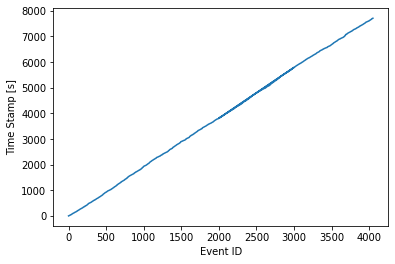

In [197]:
mu_id=np.array(mu_id)
mu_time_s = np.array(mu_ttt)*8e-9
mu_time_min = mu_time_s/60
plt.plot(mu_id, mu_time_s);
plt.ylabel('Time Stamp [s]')
plt.xlabel('Event ID')
plt.show()

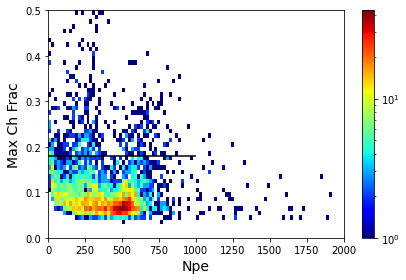

In [194]:
plt.figure()
plt.hist2d(mu_area_sum, mu_max_frac, bins=[100, 100], range=((0, 2000), (0, 1)), 
                                                   norm=colors.LogNorm(), cmap='jet');
plt.colorbar()
plt.xlabel('Npe', fontsize=14)
plt.ylabel('Max Ch Frac', fontsize=14)
plt.hlines(0.18, 0, 1000, color='k')
plt.ylim([0, 0.5])
plt.tight_layout()
plt.show()

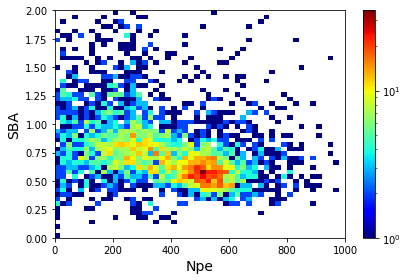

In [195]:
plt.figure()
sb=np.array(mu_area_side)/np.array(mu_area_bot)
mu_sba=(np.array(mu_area_side)-np.array(mu_area_bot))/mu_area_sum
plt.hist2d(mu_area_sum, sb, bins=[50, 50], range=((0, 1000), (0, 2)), norm=colors.LogNorm(), cmap='jet');
plt.colorbar()
plt.xlabel('Npe', fontsize=14)
plt.ylabel('SBA', fontsize=14)
plt.tight_layout()
plt.show()

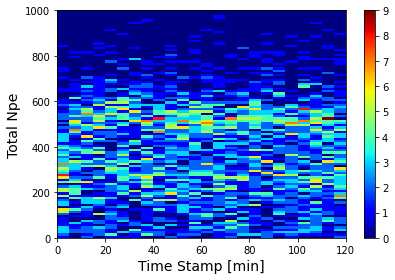

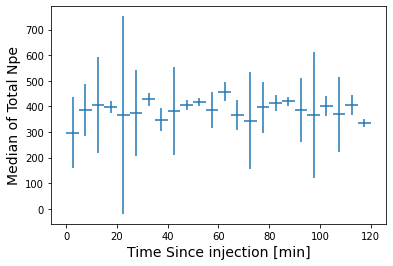

In [198]:
nbinx=24

plt.figure()
mu_area_sum=np.array(mu_area_sum)
h = plt.hist2d(mu_time_min, mu_area_sum, bins=[nbinx, 100], range=((0, 120), (0, 1000)), cmap='jet');
plt.colorbar()
plt.xlabel('Time Stamp [min]', fontsize=14)
plt.ylabel('Total Npe', fontsize=14)
plt.tight_layout()
plt.show()


def get_sliced_data(a, nbinx, tmin=0, tmax=120):
    data=[]
    dt = (tmax-tmin)/nbinx
    t_c = np.arange(tmin, tmax, dt)+dt/2
    for b in range(nbinx):
        tl = tmin+b*dt
        tr = tl+dt
        mask = np.logical_and(mu_time_min>=tl, mu_time_min<=tr)
        data.append(a[mask])

    return {
        "data":data,
        't_c':t_c,
        'dt':dt,
    }

area_slices = get_sliced_data(mu_area_sum, nbinx) 

plt.figure()
med=[]
std=[]
n=[]
for b in range(nbinx):
    med.append(np.median(area_slices['data'][b]))
    std.append(np.std(area_slices['data'][b]))
    n.append(len(area_slices['data'][b]))

t_c=area_slices['t_c']
dt=area_slices['dt']
plt.errorbar(t_c, med, xerr=dt/2, yerr=std/np.sqrt(n), linestyle='None')
plt.xlabel('Time Since injection [min]', fontsize=14)
plt.ylabel('Median of Total Npe', fontsize=14)
plt.show()

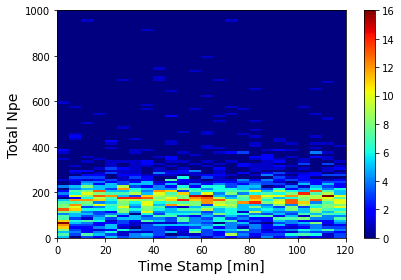

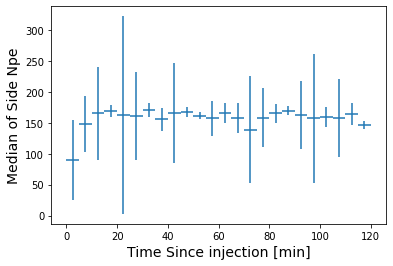

In [199]:
nbinx=24

plt.figure()
mu_area_side=np.array(mu_area_side)
h = plt.hist2d(mu_time_min, mu_area_side, bins=[nbinx, 100], range=((0, 120), (0, 1000)), cmap='jet');
plt.colorbar()
plt.xlabel('Time Stamp [min]', fontsize=14)
plt.ylabel('Total Npe', fontsize=14)
plt.tight_layout()
plt.show()


area_slices = get_sliced_data(mu_area_side, nbinx) 

plt.figure()
med=[]
std=[]
n=[]
for b in range(nbinx):
    med.append(np.median(area_slices['data'][b]))
    std.append(np.std(area_slices['data'][b]))
    n.append(len(area_slices['data'][b]))

t_c=area_slices['t_c']
dt=area_slices['dt']
plt.errorbar(t_c, med, xerr=dt/2, yerr=std/np.sqrt(n), linestyle='None')
plt.xlabel('Time Since injection [min]', fontsize=14)
plt.ylabel('Median of Side Npe', fontsize=14)
plt.show()

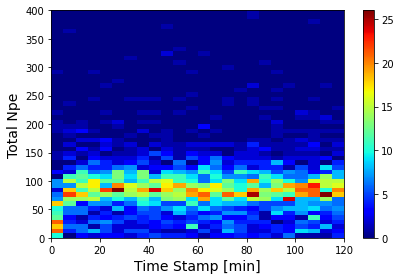

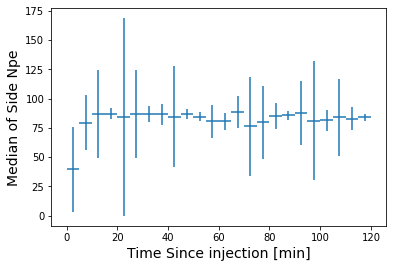

In [208]:
nbinx=24

plt.figure()
mu_area_row12 = np.array(mu_area_row1)+np.array(mu_area_row2)
h = plt.hist2d(mu_time_min, mu_area_row12, bins=[nbinx, 50], range=((0, 120), (0, 400)), cmap='jet');
plt.colorbar()
plt.xlabel('Time Stamp [min]', fontsize=14)
plt.ylabel('Total Npe', fontsize=14)
plt.tight_layout()
plt.show()

area_slices = get_sliced_data(mu_area_row12, nbinx) 

plt.figure()
med=[]
std=[]
n=[]
for b in range(nbinx):
    med.append(np.median(area_slices['data'][b]))
    std.append(np.std(area_slices['data'][b]))
    n.append(len(area_slices['data'][b]))

t_c=area_slices['t_c']
dt=area_slices['dt']
plt.errorbar(t_c, med, xerr=dt/2, yerr=std/np.sqrt(n), linestyle='None')
plt.xlabel('Time Since injection [min]', fontsize=14)
plt.ylabel('Median of Side Npe', fontsize=14)
plt.show()

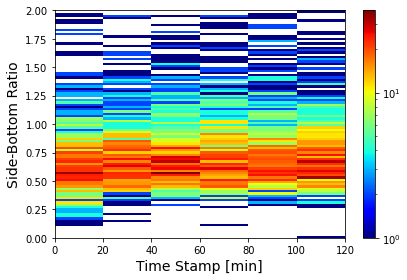

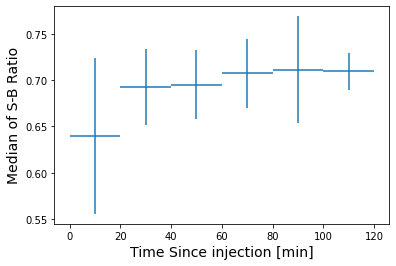

In [182]:
nbinx=6

plt.figure()
h = plt.hist2d(mu_time_min, sb, bins=[nbinx, 100], range=((0, 120), (0, 2)), norm=colors.LogNorm(), cmap='jet');
plt.colorbar()
plt.xlabel('Time Stamp [min]', fontsize=14)
plt.ylabel('Side-Bottom Ratio', fontsize=14)
plt.tight_layout()
plt.show()



sb_slices=[]
tmin=0
tmax=120
dt = (tmax-tmin)/nbinx
t_c = np.arange(tmin, tmax, dt)+dt/2
for b in range(nbinx):
    tl = tmin+b*dt
    tr = tl+dt
    mask = np.logical_and(mu_time_min>=tl, mu_time_min<=tr)
    sb_slices.append(sb[mask])


plt.figure()
med=[]
std=[]
n=[]
for b in range(nbinx):
    med.append(np.median(sb_slices[b]))
    std.append(np.std(sb_slices[b]))
    n.append(len(sb_slices[b]))

plt.errorbar(t_c, med, xerr=dt/2, yerr=std/np.sqrt(n), linestyle='None')
plt.xlabel('Time Since injection [min]', fontsize=14)
plt.ylabel('Median of S-B Ratio', fontsize=14)
plt.show()

# A chunk of WbLS data

In [79]:
data_files=[
    "phase1_muon_wbls_1pct_220921T1609_rq.root",
    "phase1_muon_wbls_1pct_220921T2022_rq.root",
    "phase1_muon_wbls_1pct_220922T0007_rq.root",
    "phase1_muon_wbls_1pct_220922T0814_rq.root",
    "phase1_muon_wbls_1pct_220922T1645_rq.root",
    "phase1_muon_wbls_1pct_220922T2302_rq.root",
    "phase1_muon_wbls_1pct_220923T0754_rq.root",
    "phase1_muon_wbls_1pct_220923T1808_rq.root",
    "phase1_muon_wbls_1pct_220923T2317_rq.root",
    "phase1_muon_wbls_1pct_220924T0748_rq.root",
    "phase1_muon_wbls_1pct_220924T1753_rq.root",
#     "phase1_muon_wbls_1pct_220925T0401_rq.root",
    "phase1_muon_wbls_1pct_220925T1143_rq.root",
    "phase1_muon_wbls_1pct_220925T2152_rq.root",
    "phase1_muon_wbls_1pct_220926T0018_rq.root",
    "phase1_muon_wbls_1pct_220926T0705_rq.root",
    "phase1_muon_wbls_1pct_220926T1500_rq.root",
    "phase1_muon_wbls_1pct_220927T0055_rq.root",
    "phase1_muon_wbls_1pct_220927T1023_rq.root",
]

data_files_w=[
    "phase0_muon_water_220913T0036_rq.root",
    "phase0_muon_water_220913T0831_rq.root",
    "phase0_muon_water_220913T1107_rq.root",
    "phase0_muon_water_220913T2307_rq.root",
    "phase0_muon_water_220914T0019_rq.root",
    "phase0_muon_water_220914T0939_rq.root",
    "phase0_muon_water_220914T1802_rq.root",
    "phase0_muon_water_220915T0002_rq.root",
    "phase0_muon_water_220915T0955_rq.root",
    "phase0_muon_water_220915T2110_rq.root",
    "phase0_muon_water_220916T0109_rq.root",
    "phase0_muon_water_220916T0908_rq.root",
    "phase0_muon_water_220916T1826_rq.root",
    "phase0_muon_water_220917T0020_rq.root",
    "phase0_muon_water_220917T0835_rq.root",
    "phase0_muon_water_220917T2131_rq.root",
    "phase0_muon_water_220918T0002_rq.root",
    "phase0_muon_water_220918T0854_rq.root",
    "phase0_muon_water_220918T1459_rq.root",
    "phase0_muon_water_220918T1559_rq.root",
    "phase0_muon_water_220918T2112_rq.root",
    "phase0_muon_water_220918T2328_rq.root",
    "phase0_muon_water_220919T0656_rq.root",
    "phase0_muon_water_220919T1743_rq.root",
    "phase0_muon_water_220920T0054_rq.root",
    "phase0_muon_water_220920T1046_rq.root",
    "phase0_muon_water_220920T1725_rq.root",
]

dt_list=[]
for i in data_files:
    dt_list.append(extract_datetime_from_str(i))
dt_list_w=[]
for i in data_files_w:
    dt_list_w.append(extract_datetime_from_str(i))

# sometimes, it's faster if not to load channel level variables
# var_names = []
# f = uproot.open(file_paths[0])
# for k in f['event'].keys():
#     if k[:3]=='ch_':
#         continue
#     var_names.append(k)
file_paths = make_file_paths('../data/rq/v1.0.1e/', data_files)
file_paths_w = make_file_paths('../data/rq/v1.0.1e/', data_files_w)
rq = get_concatenated_data(file_paths)
rq_w = get_concatenated_data(file_paths_w)

In [5]:
def add_bottom_bary_centers(rq):
    ch_id= [101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 
                  112, 113, 114, 115, 200, 201, 202, 203,
                 204, 205, 206, 207, 208, 209, 210, 
                  211, 212, 213, 214]
    pmt_x=np.array([381., 381., 381., 381., 
                      190.5, 190.5, 190.5, 190.5, 190.5, 190.5, 190.5, 
                      0., 0., 0., 0., 0., 0., 0., 0.,
                      -190.5, -190.5, -190.5, -190.5, -190.5, -190.5, -190.5, 
                      -381., -381., -381., -381.])
    pmt_y=np.array([-171.45, -57.15, 57.15, 171.45, 
                       -342.9, -228.6, -114.3, 0., 114.3, 228.6, 342.9, 
                       -400.05, -285.75, -171.45,-57.15, 57.15, 171.45, 285.75, 400.05, 
                       -342.9, -228.6, -114.3, 0., 114.3, 228.6, 342.9, 
                       -171.45, -57.15, 57.15, 171.45])
    tot_area = np.zeros(len(rq['event_id']))
    bary_x = np.zeros(len(rq['event_id']))
    bary_y = np.zeros(len(rq['event_id']))
    for j, this_ch in enumerate(ch_id):
        ch_mask = rq['ch_id']==this_ch
        ch_area=rq['ch_roi1_area_pe'][ch_mask].flatten()
        tot_area += ch_area
        bary_x += ch_area*pmt_x[j]
        bary_y += ch_area*pmt_y[j]
    bary_x /= tot_area
    bary_y /= tot_area
#     bary_x = np.zeros(len(rq['event_id']))
#     bary_y = np.zeros(len(rq['event_id']))
#     for i in range(len(rq['event_id'])):
#         if i>10:
#             continue
#         ch_area = rq['ch_roi1_area_pe'][i][0:30]
#         bary_x[i] = np.sum(ch_area*pmt_x)/np.sum(ch_area)
#         bary_y[i] = np.sum(ch_area*pmt_y)/np.sum(ch_area)
    rq['bary_x']=bary_x
    rq['bary_y']=bary_y
    rq['sum_roi1_area_pe']=tot_area
    return rq

In [ ]:
rq = add_bottom_bary_centers(rq)
rq_w = add_bottom_bary_centers(rq_w)

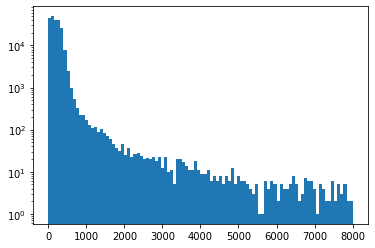

In [17]:
plt.hist(rq['sum_roi1_area_pe'], bins=100, range=(0, 8000));
plt.yscale('log')

In [18]:
rq.keys()

dict_keys(['event_id', 'event_ttt', 'event_sanity', 'event_saturated', 'ch_id', 'ch_saturated', 'ch_roi0_height_pe', 'ch_roi1_height_pe', 'ch_roi2_height_pe', 'ch_roi0_area_pe', 'ch_roi1_area_pe', 'ch_roi2_area_pe', 'ch_roi0_low_pe', 'ch_roi1_low_pe', 'ch_roi2_low_pe', 'ch_roi0_std_pe', 'ch_roi1_std_pe', 'ch_roi2_std_pe', 'aux_ch_id', 'aux_ch_area_mV', 'npulse', 'pulse_id', 'pulse_start', 'pulse_end', 'pulse_area_sum_pe', 'pulse_area_bot_pe', 'pulse_area_side_pe', 'pulse_area_row1_pe', 'pulse_area_row2_pe', 'pulse_area_row3_pe', 'pulse_area_row4_pe', 'pulse_area_col1_pe', 'pulse_area_col2_pe', 'pulse_area_col3_pe', 'pulse_area_col4_pe', 'pulse_area_user_pe', 'pulse_aft10_sum_ns', 'pulse_aft10_bot_ns', 'pulse_aft10_side_ns', 'pulse_aft10_row1_ns', 'pulse_aft10_row2_ns', 'pulse_aft10_row3_ns', 'pulse_aft10_row4_ns', 'pulse_height_sum_pe', 'pulse_height_bot_pe', 'pulse_height_side_pe', 'pulse_sba', 'pulse_ptime_ns', 'pulse_coincidence', 'pulse_area_max_frac', 'pulse_area_max_ch_id', 'puls

In [20]:
mask= (rq['npulse']>0)
area=rq['pulse_area_bot_pe'][mask]
mf = rq['pulse_area_max_frac'][mask]
area0 = np.zeros(len(area))
mf0 = np.zeros(len(mf))
for i in range(len(area)):
    area0[i] = area[i][0]
    mf0[i] = mf[i][0]

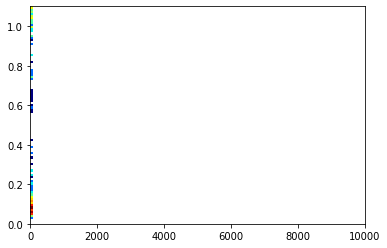

In [21]:
plt.hist2d(area0, mf0, bins=[100, 100], range=((0, 10000),(0, 1.1)), 
           norm=colors.LogNorm(), cmap='jet');

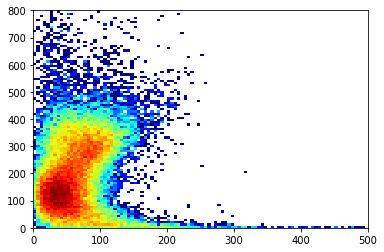

In [687]:
r = np.sqrt(np.square(rq['bary_x'])+np.square(rq['bary_y']))
plt.hist2d(r, rq['sum_roi1_area_pe'], bins=[100, 100], range=((0, 500),(0, 800)), 
           norm=colors.LogNorm(), cmap='jet');


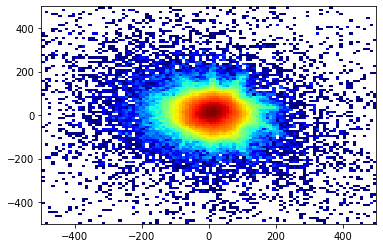

In [22]:
plt.hist2d(rq['bary_x'], rq['bary_y'], bins=[100, 100], range=((-500,500),(-500, 500)), 
           norm=colors.LogNorm(), cmap='jet');


In [625]:
rq.keys()

dict_keys([])

In [541]:
# it's a lot faster if not to load channel level variables
# var_names = []
# f = uproot.open(file_paths[0])
# for k in f['event'].keys():
#     if k[:3]=='ch_':
#         continue
#     var_names.append(k)

# rq_list = get_listed_data(file_paths, var_names=var_names)
# run_dt = get_listed_run_start_datetime(file_paths)

In [564]:
rq.keys()

dict_keys(['event_id', 'event_ttt', 'event_sanity', 'event_saturated', 'aux_ch_id', 'aux_ch_area_mV', 'npulse', 'pulse_id', 'pulse_start', 'pulse_end', 'pulse_area_sum_pe', 'pulse_area_bot_pe', 'pulse_area_side_pe', 'pulse_area_row1_pe', 'pulse_area_row2_pe', 'pulse_area_row3_pe', 'pulse_area_row4_pe', 'pulse_area_col1_pe', 'pulse_area_col2_pe', 'pulse_area_col3_pe', 'pulse_area_col4_pe', 'pulse_area_user_pe', 'pulse_height_sum_pe', 'pulse_height_bot_pe', 'pulse_height_side_pe', 'pulse_sba', 'pulse_ptime_ns', 'pulse_coincidence', 'pulse_area_max_frac', 'pulse_area_max_ch_id', 'pulse_saturated'])

Text(0.5, 0, 'Charge [pC]')

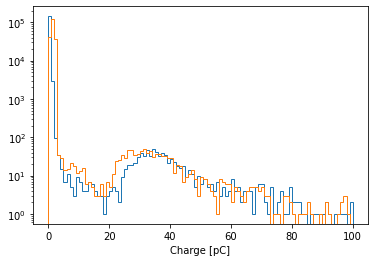

In [565]:
pad_pC={100:[], 215:[]}
for i in range(len(rq['event_id'])):
    for j, ch_id in enumerate(rq['aux_ch_id'][i]):
        pad_pC[ch_id].append( rq['aux_ch_area_mV'][i][j]/50 )
plt.hist(pad_pC[100], bins=100, range=(0, 100), histtype='step', label='bot pad 1');
plt.hist(pad_pC[215], bins=100, range=(0, 100), histtype='step', label='bot pad 1');
plt.yscale('log')
plt.xlabel('Charge [pC]')
# cross_muon = np.any(pad_pC>15)

In [566]:
rq.keys()

dict_keys(['event_id', 'event_ttt', 'event_sanity', 'event_saturated', 'aux_ch_id', 'aux_ch_area_mV', 'npulse', 'pulse_id', 'pulse_start', 'pulse_end', 'pulse_area_sum_pe', 'pulse_area_bot_pe', 'pulse_area_side_pe', 'pulse_area_row1_pe', 'pulse_area_row2_pe', 'pulse_area_row3_pe', 'pulse_area_row4_pe', 'pulse_area_col1_pe', 'pulse_area_col2_pe', 'pulse_area_col3_pe', 'pulse_area_col4_pe', 'pulse_area_user_pe', 'pulse_height_sum_pe', 'pulse_height_bot_pe', 'pulse_height_side_pe', 'pulse_sba', 'pulse_ptime_ns', 'pulse_coincidence', 'pulse_area_max_frac', 'pulse_area_max_ch_id', 'pulse_saturated'])

In [546]:
# plot_range=[0, 700]
# nbinx=100

# ncol=3
# nrow=len(rq_list)//ncol+1
# fig, ax = plt.subplots(nrow, ncol, figsize=[5*ncol,3.5*nrow])
# ax = ax.flatten()
# for r, rq in enumerate(rq_list):
#     mask_bt_p2 = rq['ch_id']==102
#     a = rq['ch_roi1_area_pe'][mask_bt_p2].flatten()  
#     h0 = ax[r].hist(a, range=plot_range, bins=nbinx, label= r'%s' % run_dt[r].strftime('%y%m%dT%H%M'),  
#          histtype='step', color='red')

#     ax[r].set_xlabel('Channel Npe', fontsize=14)
#     ax[r].set_yscale('log')
# #     ax[r].set_title(start_time_str[r], fontsize=14)
#     ax[r].legend(fontsize=10, loc='upper right')
# plt.tight_layout()
# plt.show()

In [380]:
# rq = rq_list[2]
# mask_bt_p2=(rq['ch_id']==102)
# ch_roi1_area_pe=rq['ch_roi1_area_pe']
# time_min=rq['event_ttt']*8e-9/60
# npe_bt_p2 = rq['ch_roi1_area_pe'][mask_bt_p2].flatten()  

# tmax = np.max(time_min)
# nbinx = int(tmax/5+0.5)
# plt.hist2d(time_min, npe_bt_p2, bins=[nbinx, 100], range=((0,tmax),(0, 100)), norm=colors.LogNorm(), cmap='jet');
# plt.xlabel('Time elapsed since run start [min]', fontsize=14)
# plt.ylabel('Channel Npe', fontsize=14)
# plt.show()

In [293]:
# rq_ch = get_concatenated_data(file_paths, var_names=var_names)

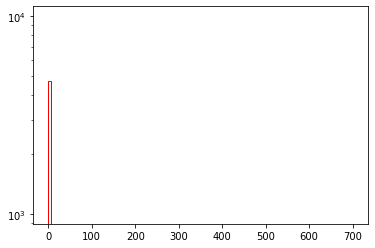

In [289]:

# a = rq['ch_roi0_std_pe'][mask_bt_p6].flatten()  
# plt.hist(a, range=plot_range, bins=nbinx,  
#      histtype='step', color='red');
# plt.yscale('log')

In [14]:
def apply_muon_cuts(rq):
    event_mask = (rq['npulse']>0) & (rq['event_sanity']==0)
    for k in rq.keys():
        rq[k] = rq[k][event_mask]
    n_evts = len(rq['event_id'])
    event_id = rq['event_id']
    area_sum = np.zeros(n_evts)
    area_bot = np.zeros(n_evts)
    area_side = np.zeros(n_evts)
    area_row12 = np.zeros(n_evts)
    area_row34 = np.zeros(n_evts)
    area_row1 = np.zeros(n_evts)
    area_row2 = np.zeros(n_evts)
    area_row3 = np.zeros(n_evts)
    area_row4 = np.zeros(n_evts)
    area_col1 = np.zeros(n_evts)
    area_col2 = np.zeros(n_evts)
    area_col3 = np.zeros(n_evts)
    area_col4 = np.zeros(n_evts)
    peak_time = np.zeros(n_evts)
    bary_r = np.zeros(n_evts)
    bary_theta = np.zeros(n_evts)
    area_sum_crx = []
    area_bot_crx = []
    area_side_crx = []
    area_row12_crx = []
    area_row34_crx = []
    area_sb_crx = []
    bary_x_crx = []
    bary_y_crx = []
    
    for i in range(n_evts):
        area_sum[i] = rq['pulse_area_sum_pe'][i][0]
        area_bot[i] =  rq['pulse_area_bot_pe'][i][0]
        area_side[i] =  rq['pulse_area_side_pe'][i][0]
        area_col1[i] = rq['pulse_area_col1_pe'][i][0]
        area_col2[i] = rq['pulse_area_col2_pe'][i][0]
        area_col3[i] = rq['pulse_area_col3_pe'][i][0]
        area_col4[i] = rq['pulse_area_col4_pe'][i][0]
        area_row1[i] = rq['pulse_area_row1_pe'][i][0]
        area_row2[i] = rq['pulse_area_row2_pe'][i][0]
        area_row3[i] = rq['pulse_area_row3_pe'][i][0]
        area_row4[i] = rq['pulse_area_row4_pe'][i][0]
        area_row12[i] =  area_row1[i] + area_row2[i]
        area_row34[i] =  area_row3[i] + area_row4[i]
        peak_time[i] = rq['pulse_ptime_ns'][i][0]
        bary_r[i] = np.sqrt(np.square(rq['bary_x'][i])+np.square(rq['bary_y'][i]))
        bary_theta[i] = np.arctan(rq['bary_y'][i]/rq['bary_x'][i])
    
        pad_pC = rq['aux_ch_area_mV'][i]/50
        cross_muon = np.any(pad_pC>15)
        if cross_muon:
            area_sum_crx.append( rq['pulse_area_sum_pe'][i][0])
            area_bot_crx.append(rq['pulse_area_bot_pe'][i][0])
            area_side_crx.append(rq['pulse_area_side_pe'][i][0])
            area_row12_crx.append(rq['pulse_area_row1_pe'][i][0]+rq['pulse_area_row2_pe'][i][0])
            area_row34_crx.append(rq['pulse_area_row3_pe'][i][0]+rq['pulse_area_row4_pe'][i][0])
            area_sb_crx.append(rq['pulse_area_side_pe'][i][0]/rq['pulse_area_bot_pe'][i][0])
            bary_x_crx.append(rq['bary_x'][i])
            bary_y_crx.append(rq['bary_y'][i])
            
    return dict(
        n_evts=n_evts,
        event_id=event_id,
        area_sum=area_sum,
        area_bot=area_bot,
        area_side=area_side,
        area_row1=area_row1,
        area_row2=area_row2,
        area_row3=area_row3,
        area_row4=area_row4,
        area_row12=area_row12,
        area_row34=area_row34,
        area_col1=area_col1,
        area_col2=area_col2,
        area_col3=area_col3,
        area_col4=area_col4,
        peak_time=peak_time,
        bary_r=bary_r,
        bary_theta=bary_theta,
        bary_x = rq['bary_x'],
        bary_y = rq['bary_y'],
        area_sum_crx=np.array(area_sum_crx),
        area_bot_crx=np.array(area_bot_crx),
        area_side_crx=np.array(area_side_crx),
        area_row12_crx=np.array(area_row12_crx),
        area_row34_crx=np.array(area_row34_crx),
        area_sb_crx=np.array(area_sb_crx),
        bary_x_crx=np.array(bary_x_crx),
        bary_y_crx=np.array(bary_y_crx),
    )

In [24]:
mu_rq=apply_muon_cuts(rq)
mu_rq_w=apply_muon_cuts(rq_w)

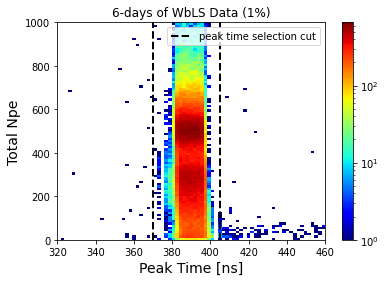

In [25]:
plt.figure()
h = plt.hist2d(mu_rq['peak_time'], mu_rq['area_sum'], bins=[75, 100], range=((320, 460), (0, 1000)), norm=colors.LogNorm(), cmap='jet');
plt.vlines([370, 405], 0, 1e4, color='k', linestyle='--', linewidth=2, label='peak time selection cut')
plt.colorbar()
plt.xlabel('Peak Time [ns]', fontsize=14)
plt.ylabel('Total Npe', fontsize=14)
plt.title('6-days of WbLS Data (1%)')
plt.ylim([0, 1000])
plt.legend()
plt.show()

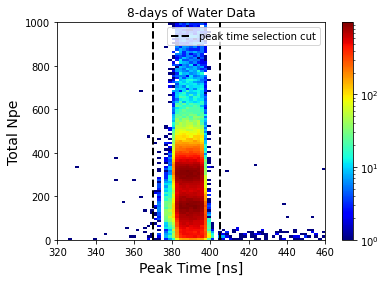

In [26]:
plt.figure()
h = plt.hist2d(mu_rq_w['peak_time'], mu_rq_w['area_sum'], bins=[75, 100], range=((320, 460), (0, 1000)), norm=colors.LogNorm(), cmap='jet');
plt.vlines([370, 405], 0, 1e4, color='k', linestyle='--', linewidth=2, label='peak time selection cut')
plt.colorbar()
plt.xlabel('Peak Time [ns]', fontsize=14)
plt.ylabel('Total Npe', fontsize=14)
plt.title('8-days of Water Data')
plt.legend()
plt.ylim([0, 1000])
plt.show()

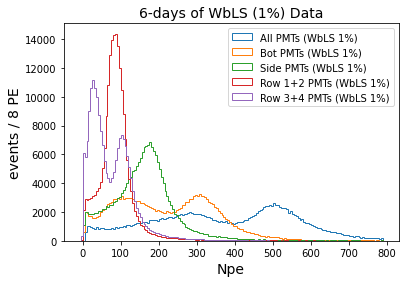

In [27]:
color_list=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
plot_crossing_muon=False
plot_range=[-10, 790]
nbinx=160

plt.figure()
time_mask= (mu_rq['peak_time']>=370) & (mu_rq['peak_time']<405)
plt.hist(mu_rq['area_sum'][time_mask], bins=nbinx, range=plot_range, 
         label='All PMTs (WbLS 1%)', histtype='step', color=color_list[0])
plt.hist(mu_rq['area_bot'][time_mask], bins=nbinx, range=plot_range, 
         label='Bot PMTs (WbLS 1%)',  histtype='step', color=color_list[1])
plt.hist(mu_rq['area_side'][time_mask], bins=nbinx, range=plot_range,
         label='Side PMTs (WbLS 1%)', histtype='step', color=color_list[2])
plt.hist(mu_rq['area_row12'][time_mask], bins=nbinx, range=plot_range, 
         label='Row 1+2 PMTs (WbLS 1%)', histtype='step', color=color_list[3])
plt.hist(mu_rq['area_row34'][time_mask], bins=nbinx, range=plot_range, 
         label='Row 3+4 PMTs (WbLS 1%)', histtype='step', color=color_list[4])
if plot_crossing_muon:
    plt.hist(mu_rq['area_row34_crx'], bins=nbinx, range=plot_range, color=color_list[4], alpha=0.4)
    plt.hist(mu_rq['area_row12_crx'], bins=nbinx, range=plot_range, color=color_list[3], alpha=0.4)
    plt.hist(mu_rq['area_side_crx'], bins=nbinx, range=plot_range, color=color_list[2], alpha=0.4)
    plt.hist(mu_rq['area_bot_crx'], bins=nbinx, range=plot_range,   color=color_list[1], alpha=0.4)
    plt.hist(mu_rq['area_sum_crx'], bins=nbinx, range=plot_range,  color=color_list[0], alpha=0.4)

plt.xlabel('Npe', fontsize=14)
if plot_crossing_muon:
    plt.yscale('log')
# plt.ylim([10, 3e4])
plt.legend(fontsize=10)
plt.ylabel('events / 8 PE',  fontsize=14)
plt.title('6-days of WbLS (1%) Data', fontsize=14)
plt.show()

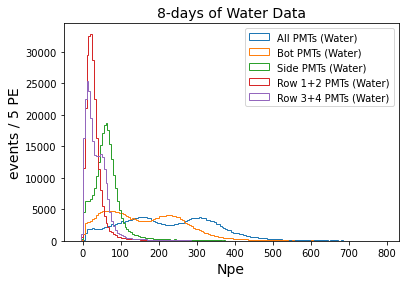

In [28]:
color_list=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
plot_crossing_muon=False
plot_range=[-10, 790]
nbinx=160

plt.figure()
time_mask= (mu_rq_w['peak_time']>=370) & (mu_rq_w['peak_time']<405)
plt.hist(mu_rq_w['area_sum'][time_mask], bins=nbinx, range=plot_range, 
         label='All PMTs (Water)', histtype='step', color=color_list[0])
plt.hist(mu_rq_w['area_bot'][time_mask], bins=nbinx, range=plot_range, 
         label='Bot PMTs (Water)',  histtype='step', color=color_list[1])
plt.hist(mu_rq_w['area_side'][time_mask], bins=nbinx, range=plot_range,
         label='Side PMTs (Water)', histtype='step', color=color_list[2])
plt.hist(mu_rq_w['area_row12'][time_mask], bins=nbinx, range=plot_range, 
         label='Row 1+2 PMTs (Water)', histtype='step', color=color_list[3])
plt.hist(mu_rq_w['area_row34'][time_mask], bins=nbinx, range=plot_range, 
         label='Row 3+4 PMTs (Water)', histtype='step', color=color_list[4])
if plot_crossing_muon:
    plt.hist(mu_rq_w['area_sum_crx'], bins=nbinx, range=plot_range,  color=color_list[0], alpha=0.4)
    plt.hist(mu_rq_w['area_bot_crx'], bins=nbinx, range=plot_range,   color=color_list[1], alpha=0.4)
    plt.hist(mu_rq_w['area_side_crx'], bins=nbinx, range=plot_range, color=color_list[2],alpha=0.4)
    plt.hist(mu_rq_w['area_row12_crx'], bins=nbinx, range=plot_range, color=color_list[3], alpha=0.4)
    plt.hist(mu_rq_w['area_row34_crx'], bins=nbinx, range=plot_range, color=color_list[4], alpha=0.4)
plt.xlabel('Npe', fontsize=14)
if plot_crossing_muon:
    plt.yscale('log')
# plt.ylim([10, 3e4])
plt.legend(fontsize=10)
plt.ylabel('events / 5 PE',  fontsize=14)
plt.title('8-days of Water Data', fontsize=14)
plt.show()

In [81]:
rq_list = get_listed_data(file_paths)
for rq in rq_list:
    rq = add_bottom_bary_centers(rq)

2022-09-21 16:09:00 7396 rchi2= 0.6125152780602904
2022-09-21 20:22:00 6498 rchi2= 1.1256694548337705
2022-09-22 00:07:00 14001 rchi2= 1.30345242468525
2022-09-22 08:14:00 15230 rchi2= 0.6184704794631483
2022-09-22 16:45:00 11287 rchi2= 0.9252561684149748
2022-09-22 23:02:00 15826 rchi2= 1.2349794487325854
2022-09-23 07:54:00 18124 rchi2= 1.8724965398349118
2022-09-23 18:08:00 9261 rchi2= 0.9420149221213792
2022-09-23 23:17:00 14889 rchi2= 0.8563338608362191
2022-09-24 07:48:00 17842 rchi2= 0.6315113022216369
2022-09-24 17:53:00 17888 rchi2= 0.6981228821780154
2022-09-25 11:43:00 18212 rchi2= 0.8000801939131035
2022-09-25 21:52:00 4363 rchi2= 0.8268748329392728
2022-09-26 00:18:00 11922 rchi2= 0.9985006465428662
2022-09-26 07:05:00 14175 rchi2= 1.4432642879312343
2022-09-26 15:00:00 18063 rchi2= 0.6697250938931715
2022-09-27 00:55:00 15530 rchi2= 1.2109493425084623
2022-09-27 10:23:00 12094 rchi2= 1.6760398092146263


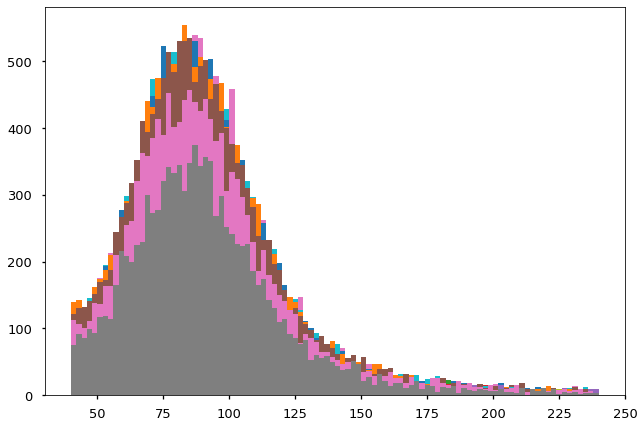

In [82]:
nbinx=100
plot_range=[40, 240]

med = []
mean = []
std = []
mean_err = []
std_err = []
for i, rq in enumerate(rq_list):
    dt = dt_list[i]
    mu_rq = apply_muon_cuts(rq)
    time_mask= (mu_rq['peak_time']>=370) & (mu_rq['peak_time']<405)
    h = plt.hist(mu_rq['area_row12'][time_mask], bins=nbinx, range=plot_range)
    res = fit_gauss(h, fit_range=[75, 110], p0=[100, 10, 100])
    mean.append(res['popt'][0])
    mean_err.append(res['err'][0])
    std.append(res['popt'][1])
    std_err.append(res['err'][1])
    print(dt, len(mu_rq['area_row12'][time_mask]), 'rchi2=', res['chi2']/res['dof'])


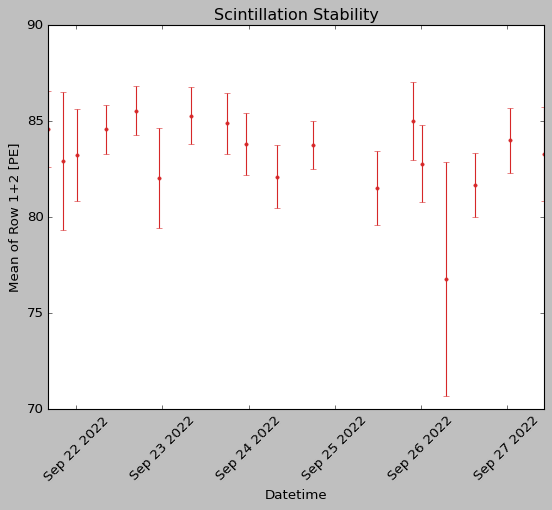

In [87]:
plt.figure()
plt.errorbar(dt_list, mean, yerr=mean_err, color='tab:red', 
               label='Row 1+2',  marker='.', linestyle = 'None')
plt.title('Scintillation Stability')
plt.ylabel('Mean of Row 1+2 [PE]')
plt.xlabel('Datetime')
plt.xticks(rotation=45)
plt.ylim([70, 90])
plt.show()

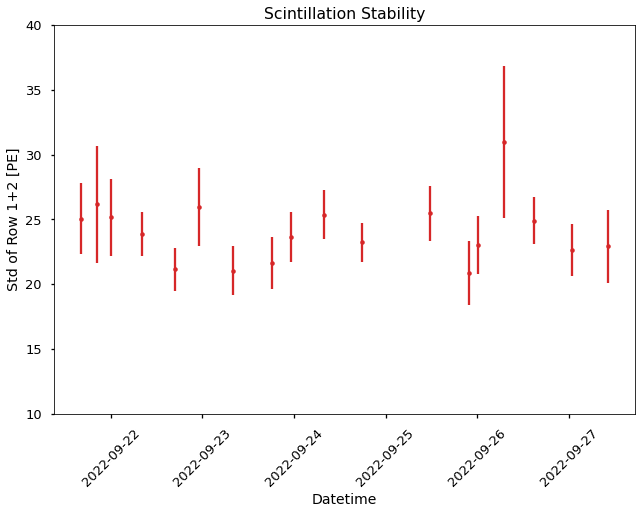

In [85]:
plt.errorbar(dt_list, std, yerr=std_err, color='tab:red', 
               label='Row 1+2',  marker='.', linestyle = 'None')
plt.title('Scintillation Stability')
plt.ylabel('Std of Row 1+2 [PE]')
plt.xlabel('Datetime', fontsize=14)
plt.xticks(rotation=45)
plt.ylim([10, 40])
plt.show()

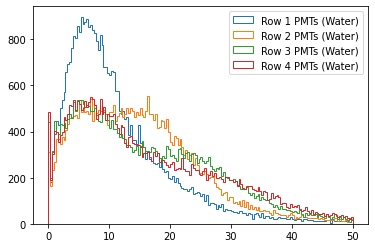

In [11]:
plot_range=[0,50]
time_mask= (mu_rq_w['peak_time']>=370) & (mu_rq_w['peak_time']<405)
plt.hist(mu_rq_w['area_row1'][time_mask], bins=nbinx, range=plot_range, 
         label='Row 1 PMTs (Water)', histtype='step');
plt.hist(mu_rq_w['area_row2'][time_mask], bins=nbinx, range=plot_range, 
         label='Row 2 PMTs (Water)', histtype='step');
plt.hist(mu_rq_w['area_row3'][time_mask], bins=nbinx, range=plot_range, 
         label='Row 3 PMTs (Water)', histtype='step');
plt.hist(mu_rq_w['area_row4'][time_mask], bins=nbinx, range=plot_range, 
         label='Row 4 PMTs (Water)', histtype='step');
plt.legend()

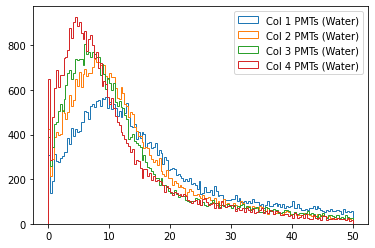

In [12]:
plot_range=[0,50]
time_mask= (mu_rq_w['peak_time']>=370) & (mu_rq_w['peak_time']<405)
plt.hist(mu_rq_w['area_col1'][time_mask], bins=nbinx, range=plot_range, 
         label='Col 1 PMTs (Water)', histtype='step');
plt.hist(mu_rq_w['area_col2'][time_mask], bins=nbinx, range=plot_range, 
         label='Col 2 PMTs (Water)', histtype='step');
plt.hist(mu_rq_w['area_col3'][time_mask], bins=nbinx, range=plot_range, 
         label='Col 3 PMTs (Water)', histtype='step');
plt.hist(mu_rq_w['area_col4'][time_mask], bins=nbinx, range=plot_range, 
         label='Col 4 PMTs (Water)', histtype='step');
plt.legend()

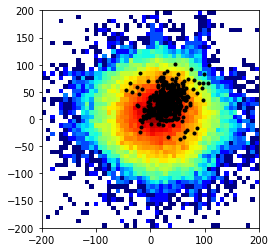

In [13]:
plt.figure(figsize=[5,4])
time_mask= (mu_rq['peak_time']>=370) & (mu_rq['peak_time']<405)
h = plt.hist2d(mu_rq['bary_x'][time_mask], mu_rq['bary_y'][time_mask], bins=[50, 50], 
               range=((-200, 200), (-200, 200)), norm=colors.LogNorm(), cmap='jet');
h = plt.scatter(mu_rq['bary_x_crx'], mu_rq['bary_y_crx'], color='k', marker='.');
plt.gca().set_aspect('equal', adjustable='box')

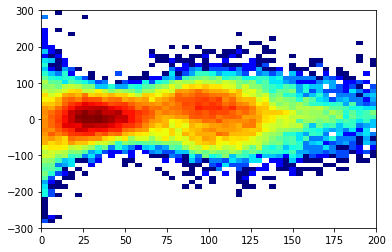

In [707]:
time_mask= (mu_rq['peak_time']>=370) & (mu_rq['peak_time']<405)
h = plt.hist2d(mu_rq['area_row34'][time_mask], mu_rq['bary_y'][time_mask], bins=[50, 50], 
               range=((0, 200), (-300, 300)), 
               norm=colors.LogNorm(), cmap='jet');

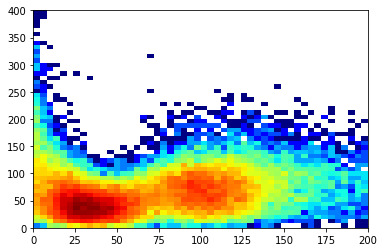

In [709]:
time_mask= (mu_rq['peak_time']>=370) & (mu_rq['peak_time']<405)
h = plt.hist2d(mu_rq['area_row34'][time_mask], mu_rq['bary_r'][time_mask], bins=[50, 50], 
               range=((0, 200), (0, 400)), 
               norm=colors.LogNorm(), cmap='jet');

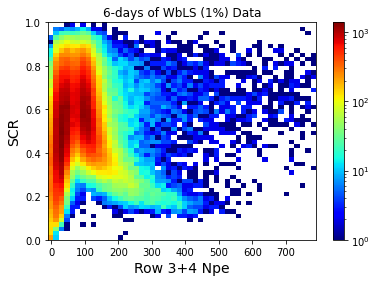

In [587]:
def calc_side_column_ratio(rq):
    scr = np.zeros(len(rq['area_col1']))
    for i in range(len(rq['area_col1'])):
        c1 = rq['area_col1'][i]
        c2 = rq['area_col2'][i]
        c3 = rq['area_col3'][i]
        c4 = rq['area_col4'][i]
        tmp = np.sort([c1, c2, c3, c4])
        scr[i] = (tmp[0]+tmp[1])/(tmp[2]+tmp[3])
    return scr

plt.figure()
scr = calc_side_column_ratio(mu_rq)
h = plt.hist2d(mu_rq['area_row34'], scr, bins=[50, 50], range=((-10, 790), (0, 1)), 
               norm=colors.LogNorm(), cmap='jet');
plt.colorbar()
plt.xlabel('Row 3+4 Npe', fontsize=14)
plt.ylabel('SCR', fontsize=14)
plt.title('6-days of WbLS (1%) Data')
plt.show()


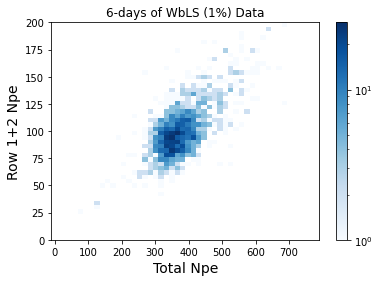

In [557]:
plt.figure()
h = plt.hist2d(rq['area_bot_crx'], rq['area_row34_crx'], bins=[50, 50], range=((-10, 790), (0, 200)), norm=colors.LogNorm(), cmap='Blues');
plt.colorbar()
plt.xlabel('Total Npe', fontsize=14)
plt.ylabel('Row 1+2 Npe', fontsize=14)
plt.title('6-days of WbLS (1%) Data')
plt.show()


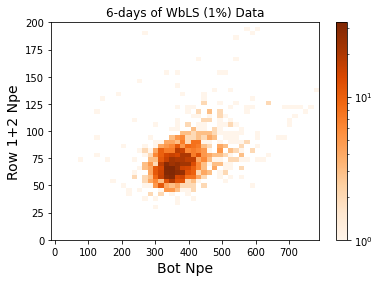

In [556]:
plt.figure()
h = plt.hist2d(rq['area_bot_crx'], rq['area_row12_crx'], bins=[50, 50], range=((-10, 790), (0, 200)), norm=colors.LogNorm(), cmap='Oranges');
plt.colorbar()
plt.xlabel('Bot Npe', fontsize=14)
plt.ylabel('Row 1+2 Npe', fontsize=14)
plt.title('6-days of WbLS (1%) Data')
plt.show()


In [618]:
def calc_bottom_bary_centers(rq):
    ch_id= [101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 
                  112, 113, 114, 115, 200, 201, 202, 203,
                 204, 205, 206, 207, 208, 209, 210, 
                  211, 212, 213, 214]
    pmt_x=dict(zip(ch_id, [381., 381., 381., 381., 
                      190.5, 190.5, 190.5, 190.5, 190.5, 190.5, 190.5, 
                      0., 0., 0., 0., 0., 0., 0., 0.,
                      -190.5, -190.5, -190.5, -190.5, -190.5, -190.5, -190.5, 
                      -381., -381., -381., -381.]))
    pmt_y=dict(zip(ch_id,  [-171.45, -57.15, 57.15, 171.45, 
                       -342.9, -228.6, -114.3, 0., 114.3, 228.6, 342.9, 
                       -400.05, -285.75, -171.45,-57.15, 57.15, 171.45, 285.75, 400.05, 
                       -342.9, -228.6, -114.3, 0., 114.3, 228.6, 342.9, 
                       -171.45, -57.15, 57.15, 171.45]))
    print(pmt_x[101], pmt_y[101])
    
    bary_x = np.zeros(len(rq['event_id']))
    bary_y = np.zeros(len(rq['event_id']))
    for i in range(len(rq['event_id'])):
        tot = 0
        for j, ch in enumerate(rq['ch_id'][i]):
            if ch_id<300:
                tot += rq['ch_roi1_area_pe'][i][j]
                bary_x[i] += ch_area*pmt_x[ch]
                bary_y[i] += ch_area*pmt_y[ch]
        bary_x[i] /= tot
        bary_y[i] /= tot
    rq['bary_x']=bary_x
    rq['bary_x']=bary_x
    return rq
        

In [617]:
key=[1,2,3,4,5]
val=[10, 20, 30, 40, 50]
d=dict(zip(key, val))
d[np.array([3,2,1,4,5])]

TypeError: unhashable type: 'numpy.ndarray'

In [15]:
file_names = ['phase0_muon_water_220913T2307_rq.root']
file_paths = make_file_paths('../data/rq/v1.0.1', file_names)
rq = get_concatenated_data(file_paths)
rq=add_bottom_bary_centers(rq)

In [16]:
mu_rq = apply_muon_cuts(rq)

[  68  273  414  433  486  547  553  753  912  931  932  933  983 1032
 1191 1375 1821 2169 2034]


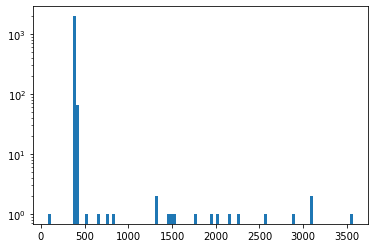

In [17]:
plt.hist(mu_rq['peak_time'], bins=100);
plt.yscale('log')
mask = mu_rq['peak_time']>500
print(mu_rq['event_id'][mask])